/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_95241/1842703782.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  freqs_tensor = torch.tensor(freqs, dtype=torch.float32, device=device)
/Users/xuenbei/Desktop/finalyearproject/spDCM/spdcm_parallel.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.k1 = torch.tensor(4.3 * self.theta0 * self.E0.item() * self.TE, device=device)
/Users/xuenbei/Desktop/finalyearproject/spDCM/spdcm_parallel.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.k2 = torch.tensor(self.epsi

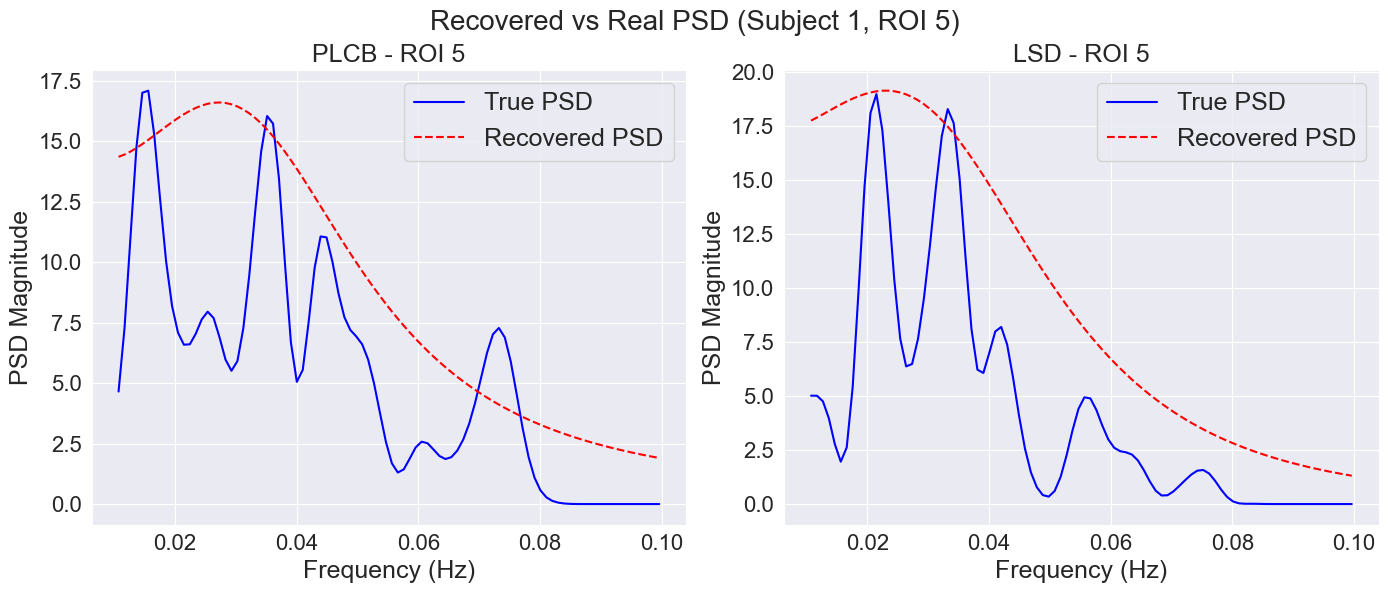

In [ ]:
import os
import json
import torch
import matplotlib.pyplot as plt
from helper_functions import load_single_time_series, filter_frequencies
from scipy_to_torch import torch_csd
from spDCM.spDCM_Model import compute_csd
from spDCM.spdcm_parallel import spDCMTrainableAll


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_model_from_pth(subject_id, roi_index, exp, ax):
    padded_id = f"{subject_id:03d}"
    base_dir = "/Users/xuenbei/Desktop/finalyearproject/spDCM/fitted_data"
    subject_dir = os.path.join(base_dir, f"sub-{padded_id}")
    prefix = f"roi-{roi_index}-{exp}"


    with open(os.path.join(subject_dir, f"{prefix}_results.json"), 'r') as f:
        results = json.load(f)
    params = results["final_parameters"]

    A = [[complex(a[0], a[1]) for a in row] for row in params["A"]]
    kwargs = dict(
        A=A,
        varphi=params["varphi"], phi=params["phi"], chi=params["chi"],
        mtt=params["mtt"], tau=params["tau"],
        alpha_v=params["alpha_v"], beta_v=params["beta_v"],
        alpha_e=params["alpha_e"], beta_e=params["beta_e"],
        alpha=params["alpha"], E0=params["E0"],
        theta0=40.3, TE=0.04, r0=15.0, epsilon=0.5
    )

    #  Load and normalise time series 
    ts_path = f"/Users/xuenbei/Desktop/finalyearproject/time_series/sub-{padded_id}-{exp}-ROI{roi_index}.txt"
    ts = load_single_time_series(ts_path)
    ts = torch.tensor(ts, dtype=torch.float32, device=device)
    ts = ts / ts.std()

    freqs, psd = torch_csd(ts, ts, fs=0.5, nperseg=128, nfft=512)
    freqs, psd = filter_frequencies(freqs, psd, min_freq=0.01, max_freq=0.1)
    freqs_tensor = torch.tensor(freqs, dtype=torch.float32, device=device)

    #  Rebuild model and load weights 
    model = spDCMTrainableAll(**kwargs).to(device)


    #  Predict CSD 
    with torch.no_grad():
        pred = compute_csd(model, freqs_tensor, model.alpha_v, model.beta_v,
                           model.alpha_e, model.beta_e, model.A, num_regions=1).squeeze().cpu()

    #  Compute magnitude of PSDs 
    true_mag = torch.sqrt(psd.real ** 2 + psd.imag ** 2).detach().cpu().numpy()
    pred_mag = torch.sqrt(pred.real ** 2 + pred.imag ** 2).numpy()

    #  Plot 
    ax.plot(freqs, true_mag, label='True PSD', color='blue')
    ax.plot(freqs, pred_mag, label='Recovered PSD', color='red', linestyle='--')
    ax.set_xlabel("Frequency (Hz)", fontsize=18)
    ax.set_ylabel("PSD Magnitude", fontsize=18)
    ax.set_title(f"{exp} - ROI {roi_index}", fontsize=18)
    ax.grid(True)
    ax.legend(fontsize=18)
    ax.tick_params(labelsize=16)


if __name__ == "__main__":
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    subject_id = 1
    roi_index = 5

    plot_model_from_pth(subject_id=subject_id, roi_index=roi_index, exp="PLCB", ax=axs[0])
    plot_model_from_pth(subject_id=subject_id, roi_index=roi_index, exp="LSD", ax=axs[1])

    fig.suptitle(f"Recovered vs Real PSD (Subject {subject_id}, ROI {roi_index})", fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()


In [ ]:

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp, ttest_rel
from statsmodels.stats.multitest import multipletests

sns.set(style="whitegrid")


base_dir = "/Users/xuenbei/Desktop/finalyearproject/spDCM/fitted_data"


subject_ids = [1, 2, 3, 4, 6, 10, 11, 12, 19, 20]
rois = list(range(0,9))

#LH VS range(0, 9)  # ROI Index 0 to 8
#RH VS range(50, 58)  # ROI Index 50 to 57
#LH somatomotor cortex range(9, 15)  # ROI Index 9 to 14
#RH somatomotor cortex range(58, 66)  # ROI Index 58 to 65
#LH Dorsal attention network range(58, 66)  # ROI Index 58 to 65
#RH Dorsal attention network range(66, 72)  # ROI Index 66 to 71
#LH Salience/Ventral Attention Network range(23, 30)  # ROI Index 23 to 29
#RH  Salience/Ventral Attention Network range(73, 77)  # ROI Index 73 to 76
#LH Limbic Network range(30, 33)  # ROI Index 30 to 32
#RH Limbic Network range(78, 80)  # ROI Index 78 to 79
#LH Control Network (Frontoparietal) range(33, 37)  # ROI Index 33 to 36
#RH Control Network (Frontoparietal) range(80, 88)  # ROI Index 80 to 87
#LH Default Mode Network range(37, 50)  # ROI Index 37 to 49
#RH Default Mode Network range(89, 100)  # ROI Index 89 to 99

params = ["phi", "varphi", "chi", "mtt", "tau", "alpha_v", "beta_v", "alpha_e", "beta_e", "alpha", "E0"]
reference_values = {
    "phi": 1.5, "varphi": 0.6, "chi": 0.6, "mtt": 2.0, "tau": 4.0,
    "alpha": 0.32, "E0": 0.4, "alpha_v": 0.5, "beta_v": 0.5,
    "alpha_e": 0.5, "beta_e": 0.5
}


all_data = []

for subj in subject_ids:
    for roi in rois:
        for condition in ["PLCB", "LSD"]:
            path = os.path.join(base_dir, f"sub-{subj:03d}", f"roi-{roi}-{condition}_results.json")
            if not os.path.exists(path):
                continue
            with open(path) as f:
                data = json.load(f).get("final_parameters", {})
            row = {"subject": subj, "roi": roi, "condition": condition}
            for param in params:
                row[param] = data.get(param, np.nan)
            all_data.append(row)

df = pd.DataFrame(all_data)
df.head()



t_results = []

for param in params:
    values = df[df["condition"] == "PLCB"][param].dropna()
    ref = reference_values.get(param, 0.0)
    if len(values) < 5:
        continue
    t_stat, p_val = ttest_1samp(values, popmean=ref)
    t_results.append({
        "parameter": param,
        "mean": values.mean(),
        "std": values.std(),
        "reference": ref,
        "t_stat": t_stat,
        "p_value": p_val
    })

results_df = pd.DataFrame(t_results)


pvals = results_df["p_value"].values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

results_df["p_fdr_bh"] = p_fdr
results_df["reject_fdr_bh"] = rej_fdr
results_df["p_bonferroni"] = p_bonf
results_df["reject_bonferroni"] = rej_bonf
results_df["p_holm"] = p_holm
results_df["reject_holm"] = rej_holm
results_df["reject_raw"] = results_df["p_value"] < 0.05


def interpret_p(p):
    if p < 0.001:
        return "highly significant"
    elif p < 0.01:
        return "significant"
    elif p < 0.05:
        return "marginally significant"
    else:
        return "not significant"

def interpret_result(p, mean, ref):
    direction = "↑ above ref" if mean > ref else "↓ below ref"
    return f"{interpret_p(p)}, {direction}"


results_df["interpret_raw"] = results_df.apply(
    lambda row: interpret_result(row["p_value"], row["mean"], row["reference"]), axis=1)
results_df["interpret_fdr_bh"] = results_df.apply(
    lambda row: interpret_result(row["p_fdr_bh"], row["mean"], row["reference"]), axis=1)
results_df["interpret_bonferroni"] = results_df.apply(
    lambda row: interpret_result(row["p_bonferroni"], row["mean"], row["reference"]), axis=1)
results_df["interpret_holm"] = results_df.apply(
    lambda row: interpret_result(row["p_holm"], row["mean"], row["reference"]), axis=1)


results_df = results_df[[
    "parameter", "mean", "std", "reference", "t_stat", "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

results_df.sort_values("p_fdr_bh", inplace=True)
results_df


,parameter,mean,std,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
6,beta_v,0.231031,0.264460,0.50,-9.648560,1.705627e-15,True,"highly significant, ↓ below ref",1.876190e-14,True,"highly significant, ↓ below ref",1.876190e-14,True,"highly significant, ↓ below ref",1.876190e-14,True,"highly significant, ↓ below ref"
3,mtt,3.149671,1.219293,2.00,8.945130,4.879606e-14,True,"highly significant, ↑ above ref",2.683783e-13,True,"highly significant, ↑ above ref",5.367566e-13,True,"highly significant, ↑ above ref",4.879606e-13,True,"highly significant, ↑ above ref"
4,tau,8.394235,6.605641,4.00,6.310875,1.055297e-08,True,"highly significant, ↑ above ref",3.869423e-08,True,"highly significant, ↑ above ref",1.160827e-07,True,"highly significant, ↑ above ref",9.497674e-08,True,"highly significant, ↑ above ref"
8,beta_e,0.326903,0.293698,0.50,-5.591246,2.443640e-07,True,"highly significant, ↓ below ref",6.720009e-07,True,"highly significant, ↓ below ref",2.688004e-06,True,"highly significant, ↓ below ref",1.954912e-06,True,"highly significant, ↓ below ref"
10,E0,0.432270,0.131246,0.40,2.332532,2.192850e-02,True,"marginally significant, ↑ above ref",4.824269e-02,True,"marginally significant, ↑ above ref",2.412135e-01,False,"not significant, ↑ above ref",1.534995e-01,False,"not significant, ↑ above ref"
7,alpha_e,0.447178,0.291652,0.50,-1.718198,8.923775e-02,False,"not significant, ↓ below ref",1.636025e-01,False,"not significant, ↓ below ref",9.816152e-01,False,"not significant, ↓ below ref",5.354265e-01,False,"not significant, ↓ below ref"
2,chi,0.612057,0.143771,0.60,0.795595,4.283842e-01,False,"not significant, ↑ above ref",5.890282e-01,False,"not significant, ↑ above ref",1.000000e+00,False,"not significant, ↑ above ref",1.000000e+00,False,"not significant, ↑ above ref"
5,alpha_v,0.526673,0.298536,0.50,0.847613,3.989271e-01,False,"not significant, ↑ above ref",5.890282e-01,False,"not significant, ↑ above ref",1.000000e+00,False,"not significant, ↑ above ref",1.000000e+00,False,"not significant, ↑ above ref"
9,alpha,0.323435,0.113886,0.32,0.286107,7.754608e-01,False,"not significant, ↑ above ref",9.477855e-01,False,"not significant, ↑ above ref",1.000000e+00,False,"not significant, ↑ above ref",1.000000e+00,False,"not significant, ↑ above ref"
0,phi,1.502239,0.268524,1.50,0.079099,9.371315e-01,False,"not significant, ↑ above ref",9.678124e-01,False,"not significant, ↑ above ref",1.000000e+00,False,"not significant, ↑ above ref",1.000000e+00,False,"not significant, ↑ above ref"


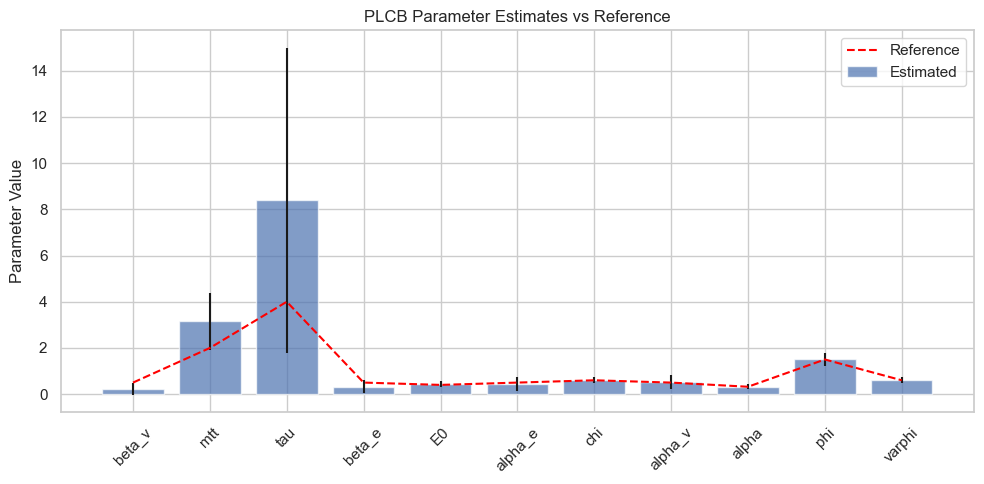

In [3]:
# Plot mean ± std vs reference (PLCB)
plt.figure(figsize=(10, 5))
x = np.arange(len(results_df))
means = results_df["mean"]
stds = results_df["std"]
refs = results_df["reference"]

plt.bar(x, means, yerr=stds, alpha=0.7, label="Estimated")
plt.plot(x, refs, color='red', linestyle='--', label="Reference")
plt.xticks(x, results_df["parameter"], rotation=45)
plt.ylabel("Parameter Value")
plt.title("PLCB Parameter Estimates vs Reference")
plt.legend()
plt.tight_layout()
plt.show()


### PLCB

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

sns.set(style="whitegrid")


df = pd.read_csv("spdcm_all_data.csv")

# Define parameters of interest
params = ["phi", "varphi", "chi", "mtt", "tau", "alpha", "E0"]

# Reference values 
reference_values = {
    "phi": 1.5, "varphi": 0.6, "chi": 0.6, "mtt": 2.0, "tau": 4.0,
    "alpha": 0.32, "E0": 0.4
}

# Define networks and associated ROI indices
network_rois = {
    "All Regions": list(range(100)),
    "LH Visual": list(range(0, 9)),
    "RH Visual": list(range(50, 58)),
    "LH Somatomotor": list(range(9, 15)),
    "RH Somatomotor": list(range(58, 66)),
    "LH Dorsal Attention": list(range(15, 23)),
    "RH Dorsal Attention": list(range(66, 72)),
    "LH Salience/Ventral Attention": list(range(23, 30)),
    "RH Salience/Ventral Attention": list(range(73, 77)),
    "LH Limbic": list(range(30, 33)),
    "RH Limbic": list(range(78, 80)),
    "LH Control": list(range(33, 37)),
    "RH Control": list(range(80, 88)),
    "LH Default Mode": list(range(37, 50)),
    "RH Default Mode": list(range(89, 100))
}

# Map ROIs to networks
roi_to_network = {}
for net, rois in network_rois.items():
    for roi in rois:
        roi_to_network[roi] = net

df["network"] = df["roi"].map(roi_to_network)

# Group and average per subject/network/condition
agg_df = df[df["parameter"].isin(params)].groupby(
    ["subject", "network", "experiment", "parameter"]
)["value"].mean().reset_index()

# Run one-sample t-tests per (network, parameter)
results = []

for net in agg_df["network"].unique():
    for param in params:
        subdf = agg_df[(agg_df["network"] == net) & (agg_df["parameter"] == param) & (agg_df["experiment"] == "PLCB")]
        if len(subdf) < 5:
            continue  # Skip if too few data points

        values = subdf["value"].dropna()
        ref = reference_values.get(param, 0.0)
        t_stat, p_val = ttest_1samp(values, popmean=ref)

        results.append({
            "network": net,
            "parameter": param,
            "mean": values.mean(),
            "std": values.std(),
            "n": len(values),
            "reference": ref,
            "t_stat": t_stat,
            "p_value": p_val
        })


results_df = pd.DataFrame(results)

# Apply FDR, Bonferroni, Holm
pvals = results_df["p_value"].values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")


results_df["p_fdr_bh"] = p_fdr
results_df["reject_fdr_bh"] = rej_fdr
results_df["p_bonferroni"] = p_bonf
results_df["reject_bonferroni"] = rej_bonf
results_df["p_holm"] = p_holm
results_df["reject_holm"] = rej_holm
results_df["reject_raw"] = results_df["p_value"] < 0.05

def interpret_p(p):
    if p < 0.001:
        return "highly significant"
    elif p < 0.01:
        return "significant"
    elif p < 0.05:
        return "marginally significant"
    else:
        return "not significant"

def interpret_result(p, mean, ref):
    direction = "↑ above ref" if mean > ref else "↓ below ref"
    return f"{interpret_p(p)}, {direction}"


results_df["interpret_raw"] = results_df.apply(
    lambda row: interpret_result(row["p_value"], row["mean"], row["reference"]), axis=1)
results_df["interpret_fdr_bh"] = results_df.apply(
    lambda row: interpret_result(row["p_fdr_bh"], row["mean"], row["reference"]), axis=1)
results_df["interpret_bonferroni"] = results_df.apply(
    lambda row: interpret_result(row["p_bonferroni"], row["mean"], row["reference"]), axis=1)
results_df["interpret_holm"] = results_df.apply(
    lambda row: interpret_result(row["p_holm"], row["mean"], row["reference"]), axis=1)


results_df = results_df[[
    "network", "parameter", "mean", "std", "n", "reference", "t_stat", "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

results_df.sort_values("network", inplace=True)
results_df


,network,parameter,mean,std,n,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
0,All Regions,phi,1.482175,0.151439,10,1.5,-0.372212,0.718349,False,"not significant, ↓ below ref",0.802411,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
1,All Regions,varphi,0.613782,0.066091,10,0.6,0.659420,0.526138,False,"not significant, ↑ above ref",0.673713,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
2,All Regions,chi,0.618817,0.054827,10,0.6,1.085338,0.305986,False,"not significant, ↑ above ref",0.486797,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
3,All Regions,mtt,2.648778,1.096449,10,2.0,1.871144,0.094127,False,"not significant, ↑ above ref",0.229844,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
4,All Regions,tau,7.881471,3.374170,10,4.0,3.637721,0.005420,True,"significant, ↑ above ref",0.023411,True,"marginally significant, ↑ above ref",0.569108,False,"not significant, ↑ above ref",0.449866,False,"not significant, ↑ above ref"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,RH Visual,varphi,0.593529,0.038664,10,0.6,-0.529247,0.609438,False,"not significant, ↓ below ref",0.725884,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
100,RH Visual,chi,0.591130,0.041368,10,0.6,-0.678080,0.514774,False,"not significant, ↓ below ref",0.672433,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
101,RH Visual,mtt,3.006876,0.399423,10,2.0,7.971558,0.000023,True,"highly significant, ↑ above ref",0.000342,True,"highly significant, ↑ above ref",0.002391,True,"significant, ↑ above ref",0.002255,True,"significant, ↑ above ref"
102,RH Visual,tau,8.990117,4.476678,10,4.0,3.524966,0.006465,True,"significant, ↑ above ref",0.023411,True,"marginally significant, ↑ above ref",0.678807,False,"not significant, ↑ above ref",0.507132,False,"not significant, ↑ above ref"


In [5]:
# Filter rows where raw p-value is not significant
nonsig_df = results_df[results_df["p_value"] >= 0.05].copy()


nonsig_df.sort_values("network", ascending=False, inplace=True)


nonsig_df

,network,parameter,mean,std,n,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
104,RH Visual,E0,0.431380,0.052093,10,0.40,1.904897,0.089187,False,"not significant, ↑ above ref",0.228406,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
100,RH Visual,chi,0.591130,0.041368,10,0.60,-0.678080,0.514774,False,"not significant, ↓ below ref",0.672433,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
99,RH Visual,varphi,0.593529,0.038664,10,0.60,-0.529247,0.609438,False,"not significant, ↓ below ref",0.725884,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
103,RH Visual,alpha,0.322977,0.034384,10,0.32,0.273794,0.790423,False,"not significant, ↑ above ref",0.855612,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
91,RH Somatomotor,phi,1.496291,0.138114,10,1.50,-0.084929,0.934177,False,"not significant, ↓ below ref",0.954265,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,All Regions,chi,0.618817,0.054827,10,0.60,1.085338,0.305986,False,"not significant, ↑ above ref",0.486797,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
1,All Regions,varphi,0.613782,0.066091,10,0.60,0.659420,0.526138,False,"not significant, ↑ above ref",0.673713,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
5,All Regions,alpha,0.310518,0.069100,10,0.32,-0.433944,0.674546,False,"not significant, ↓ below ref",0.762277,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
6,All Regions,E0,0.421495,0.093560,10,0.40,0.726517,0.485987,False,"not significant, ↑ above ref",0.654213,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"


In [6]:
# FDR BH non-significant
nonsig_fdr = results_df[results_df["reject_fdr_bh"] == False]
nonsig_fdr

,network,parameter,mean,std,n,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
0,All Regions,phi,1.482175,0.151439,10,1.50,-0.372212,0.718349,False,"not significant, ↓ below ref",0.802411,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
1,All Regions,varphi,0.613782,0.066091,10,0.60,0.659420,0.526138,False,"not significant, ↑ above ref",0.673713,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
2,All Regions,chi,0.618817,0.054827,10,0.60,1.085338,0.305986,False,"not significant, ↑ above ref",0.486797,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
3,All Regions,mtt,2.648778,1.096449,10,2.00,1.871144,0.094127,False,"not significant, ↑ above ref",0.229844,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
5,All Regions,alpha,0.310518,0.069100,10,0.32,-0.433944,0.674546,False,"not significant, ↓ below ref",0.762277,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,RH Somatomotor,phi,1.496291,0.138114,10,1.50,-0.084929,0.934177,False,"not significant, ↓ below ref",0.954265,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
103,RH Visual,alpha,0.322977,0.034384,10,0.32,0.273794,0.790423,False,"not significant, ↑ above ref",0.855612,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
99,RH Visual,varphi,0.593529,0.038664,10,0.60,-0.529247,0.609438,False,"not significant, ↓ below ref",0.725884,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
100,RH Visual,chi,0.591130,0.041368,10,0.60,-0.678080,0.514774,False,"not significant, ↓ below ref",0.672433,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"


In [7]:
# Bonferroni non-significant
nonsig_bonf = results_df[results_df["reject_bonferroni"] == False]
nonsig_bonf

,network,parameter,mean,std,n,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
0,All Regions,phi,1.482175,0.151439,10,1.5,-0.372212,0.718349,False,"not significant, ↓ below ref",0.802411,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
1,All Regions,varphi,0.613782,0.066091,10,0.6,0.659420,0.526138,False,"not significant, ↑ above ref",0.673713,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
2,All Regions,chi,0.618817,0.054827,10,0.6,1.085338,0.305986,False,"not significant, ↑ above ref",0.486797,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
3,All Regions,mtt,2.648778,1.096449,10,2.0,1.871144,0.094127,False,"not significant, ↑ above ref",0.229844,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
4,All Regions,tau,7.881471,3.374170,10,4.0,3.637721,0.005420,True,"significant, ↑ above ref",0.023411,True,"marginally significant, ↑ above ref",0.569108,False,"not significant, ↑ above ref",0.449866,False,"not significant, ↑ above ref"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,RH Visual,phi,1.562673,0.050409,10,1.5,3.931590,0.003450,True,"significant, ↑ above ref",0.018849,True,"marginally significant, ↑ above ref",0.362219,False,"not significant, ↑ above ref",0.300124,False,"not significant, ↑ above ref"
99,RH Visual,varphi,0.593529,0.038664,10,0.6,-0.529247,0.609438,False,"not significant, ↓ below ref",0.725884,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
100,RH Visual,chi,0.591130,0.041368,10,0.6,-0.678080,0.514774,False,"not significant, ↓ below ref",0.672433,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
102,RH Visual,tau,8.990117,4.476678,10,4.0,3.524966,0.006465,True,"significant, ↑ above ref",0.023411,True,"marginally significant, ↑ above ref",0.678807,False,"not significant, ↑ above ref",0.507132,False,"not significant, ↑ above ref"


In [8]:

# Holm non-significant
nonsig_holm = results_df[results_df["reject_holm"] == False]
nonsig_holm

,network,parameter,mean,std,n,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
0,All Regions,phi,1.482175,0.151439,10,1.5,-0.372212,0.718349,False,"not significant, ↓ below ref",0.802411,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
1,All Regions,varphi,0.613782,0.066091,10,0.6,0.659420,0.526138,False,"not significant, ↑ above ref",0.673713,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
2,All Regions,chi,0.618817,0.054827,10,0.6,1.085338,0.305986,False,"not significant, ↑ above ref",0.486797,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
3,All Regions,mtt,2.648778,1.096449,10,2.0,1.871144,0.094127,False,"not significant, ↑ above ref",0.229844,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
4,All Regions,tau,7.881471,3.374170,10,4.0,3.637721,0.005420,True,"significant, ↑ above ref",0.023411,True,"marginally significant, ↑ above ref",0.569108,False,"not significant, ↑ above ref",0.449866,False,"not significant, ↑ above ref"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,RH Visual,phi,1.562673,0.050409,10,1.5,3.931590,0.003450,True,"significant, ↑ above ref",0.018849,True,"marginally significant, ↑ above ref",0.362219,False,"not significant, ↑ above ref",0.300124,False,"not significant, ↑ above ref"
99,RH Visual,varphi,0.593529,0.038664,10,0.6,-0.529247,0.609438,False,"not significant, ↓ below ref",0.725884,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
100,RH Visual,chi,0.591130,0.041368,10,0.6,-0.678080,0.514774,False,"not significant, ↓ below ref",0.672433,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
102,RH Visual,tau,8.990117,4.476678,10,4.0,3.524966,0.006465,True,"significant, ↑ above ref",0.023411,True,"marginally significant, ↑ above ref",0.678807,False,"not significant, ↑ above ref",0.507132,False,"not significant, ↑ above ref"


In [ ]:
# Filter where none of the tests show significant difference
consistently_nonsig = results_df[
    (results_df["reject_raw"] == False) &
    (results_df["reject_fdr_bh"] == False) &
    (results_df["reject_bonferroni"] == False) &
    (results_df["reject_holm"] == False)
]


consistently_nonsig = consistently_nonsig.sort_values("network")


consistently_nonsig


,network,parameter,mean,std,n,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
0,All Regions,phi,1.482175,0.151439,10,1.50,-0.372212,0.718349,False,"not significant, ↓ below ref",0.802411,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
1,All Regions,varphi,0.613782,0.066091,10,0.60,0.659420,0.526138,False,"not significant, ↑ above ref",0.673713,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
2,All Regions,chi,0.618817,0.054827,10,0.60,1.085338,0.305986,False,"not significant, ↑ above ref",0.486797,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
3,All Regions,mtt,2.648778,1.096449,10,2.00,1.871144,0.094127,False,"not significant, ↑ above ref",0.229844,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
5,All Regions,alpha,0.310518,0.069100,10,0.32,-0.433944,0.674546,False,"not significant, ↓ below ref",0.762277,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,RH Somatomotor,chi,0.631554,0.062301,10,0.60,1.601627,0.143702,False,"not significant, ↑ above ref",0.306491,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
99,RH Visual,varphi,0.593529,0.038664,10,0.60,-0.529247,0.609438,False,"not significant, ↓ below ref",0.725884,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
100,RH Visual,chi,0.591130,0.041368,10,0.60,-0.678080,0.514774,False,"not significant, ↓ below ref",0.672433,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
103,RH Visual,alpha,0.322977,0.034384,10,0.32,0.273794,0.790423,False,"not significant, ↑ above ref",0.855612,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"


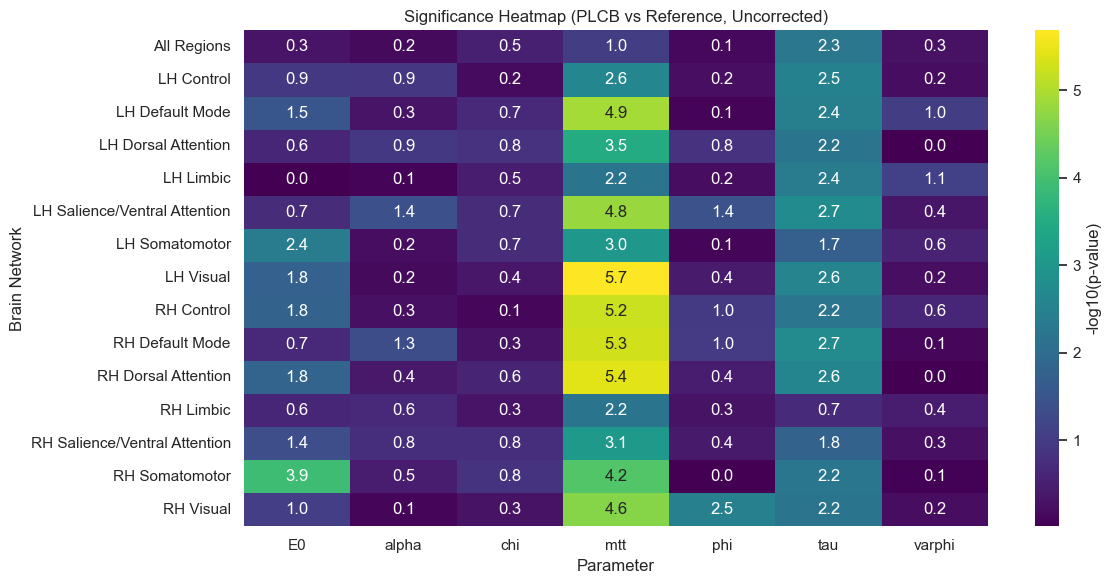

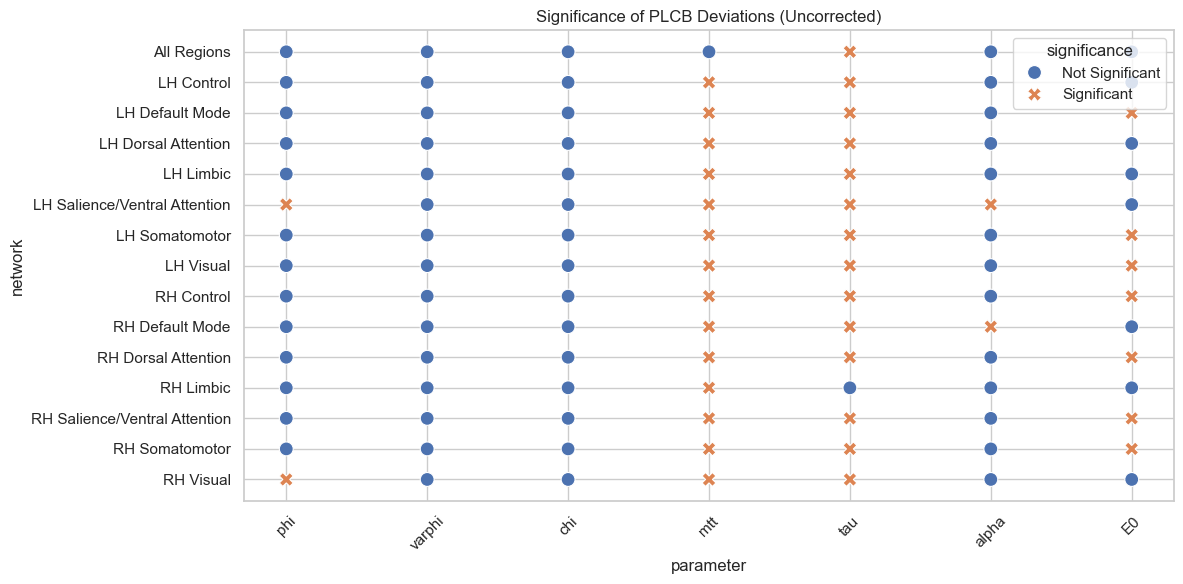

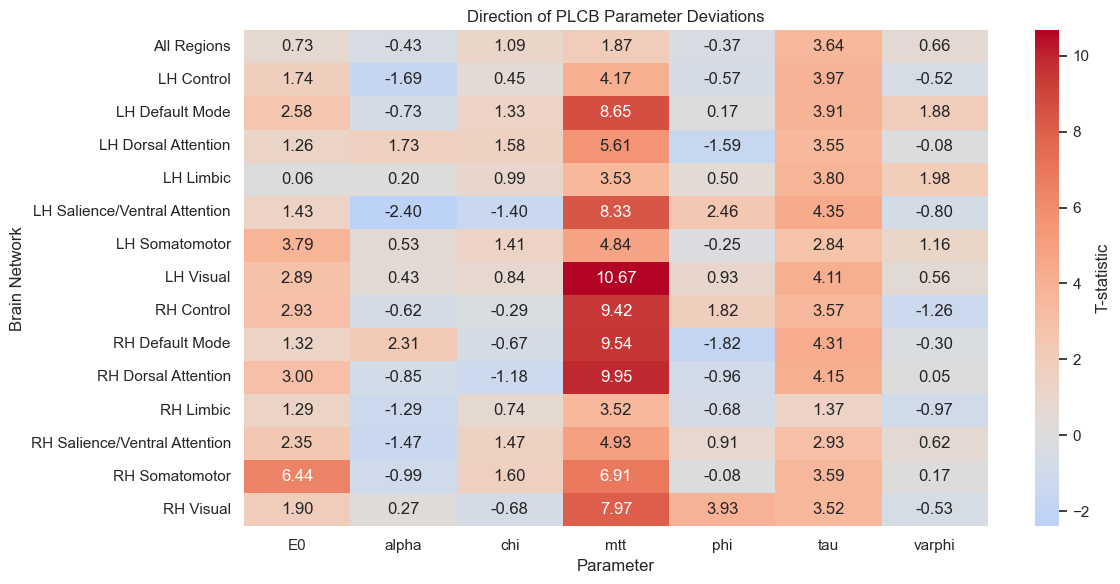

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df.pivot(index="network", columns="parameter", values="p_value")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (PLCB vs Reference, Uncorrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df["significance"] = results_df["reject_raw"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
# −log10(p-value) < 1.3 suggests non-significance at the p = 0.05 level.

plt.title("Significance of PLCB Deviations (Uncorrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

heatmap_vals = results_df.copy()

heatmap_matrix = heatmap_vals.pivot(index="network", columns="parameter", values="t_stat")

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "T-statistic"}
)
plt.title("Direction of PLCB Parameter Deviations")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()


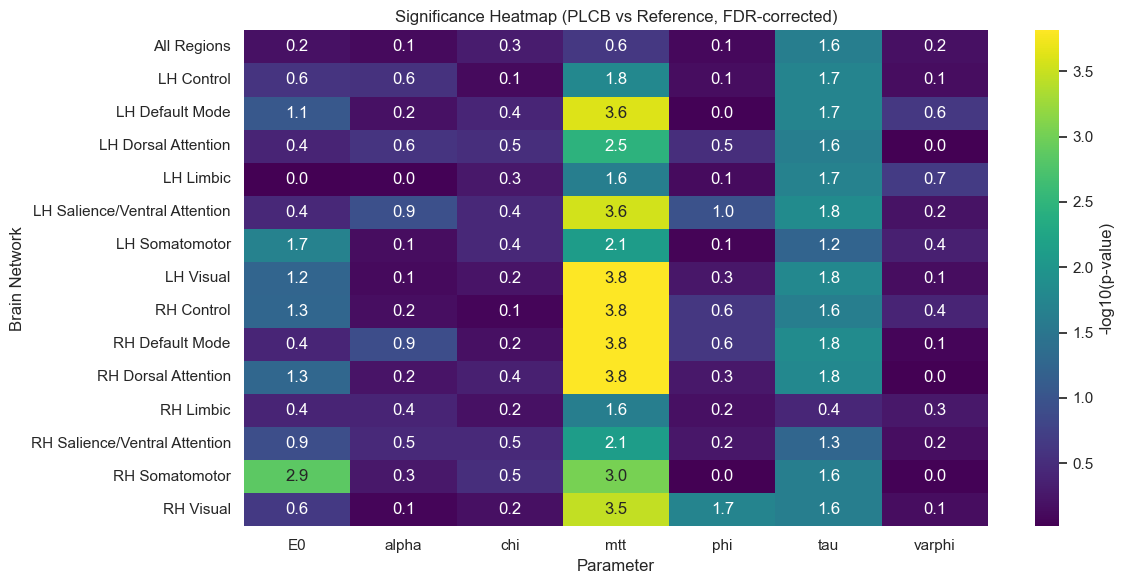

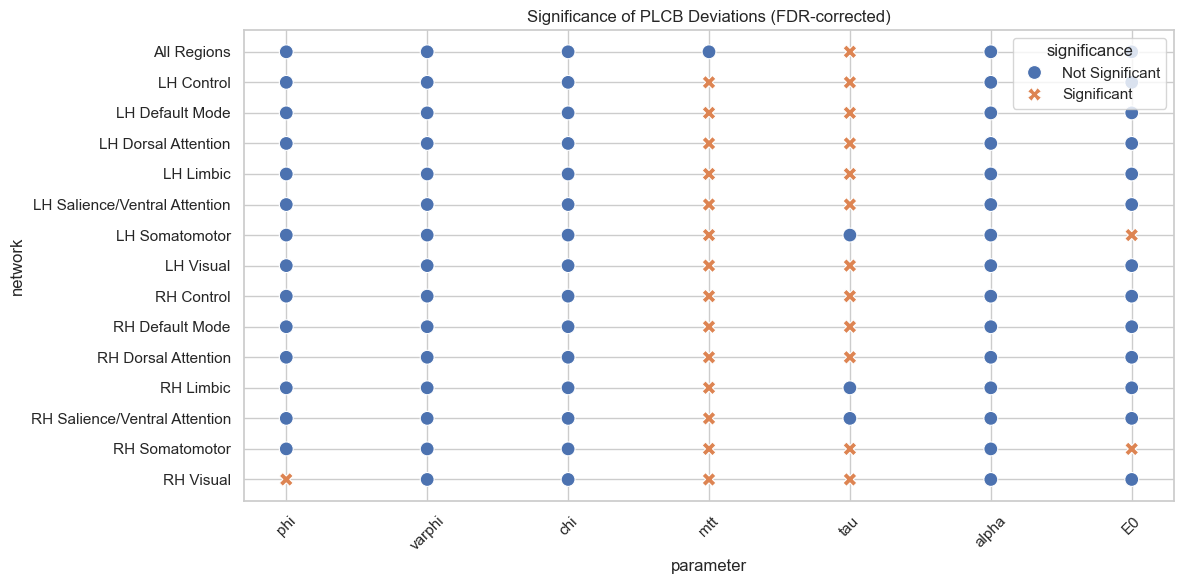

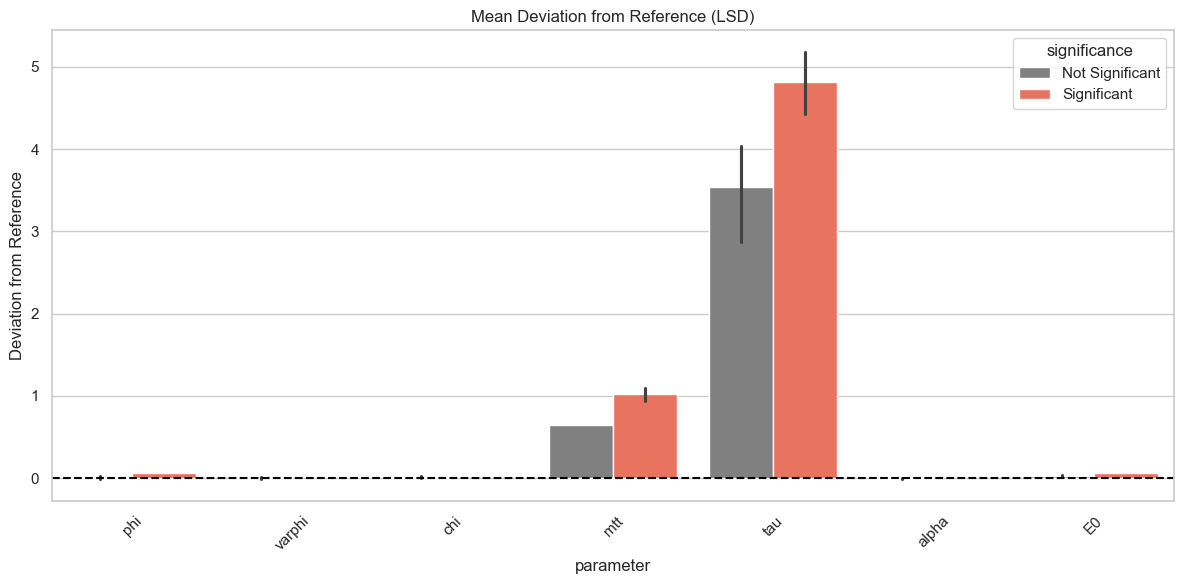

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df.pivot(index="network", columns="parameter", values="p_fdr_bh")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (PLCB vs Reference, FDR-corrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df["significance"] = results_df["reject_fdr_bh"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of PLCB Deviations (FDR-corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results_df["mean_diff"] = results_df["mean"] - results_df["reference"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df, x="parameter", y="mean_diff", hue="significance",
    palette={"Significant": "tomato", "Not Significant": "gray"}
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Mean Deviation from Reference (LSD)")
plt.ylabel("Deviation from Reference")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


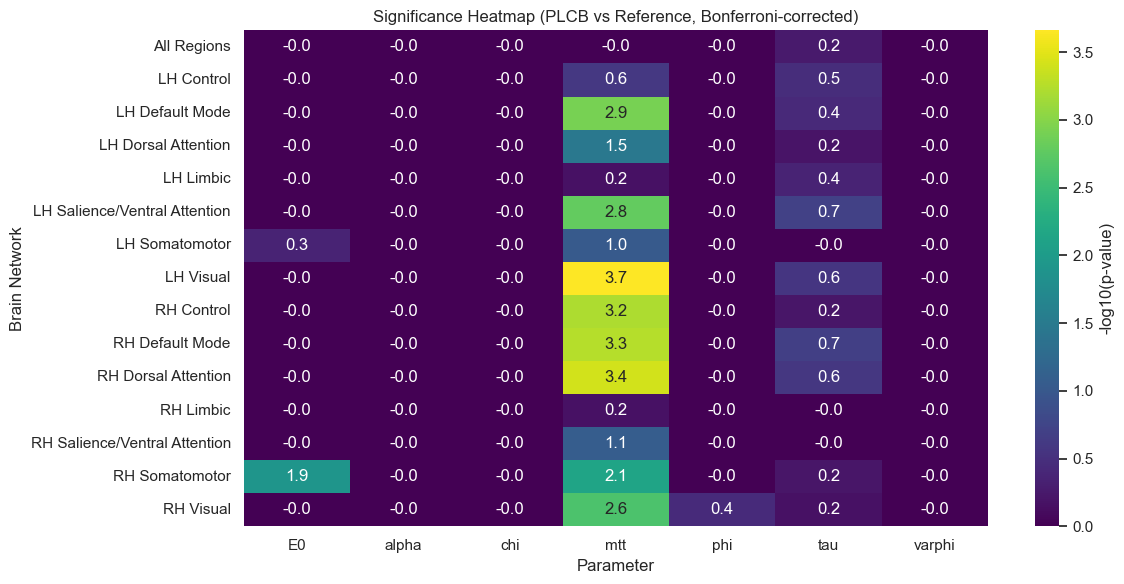

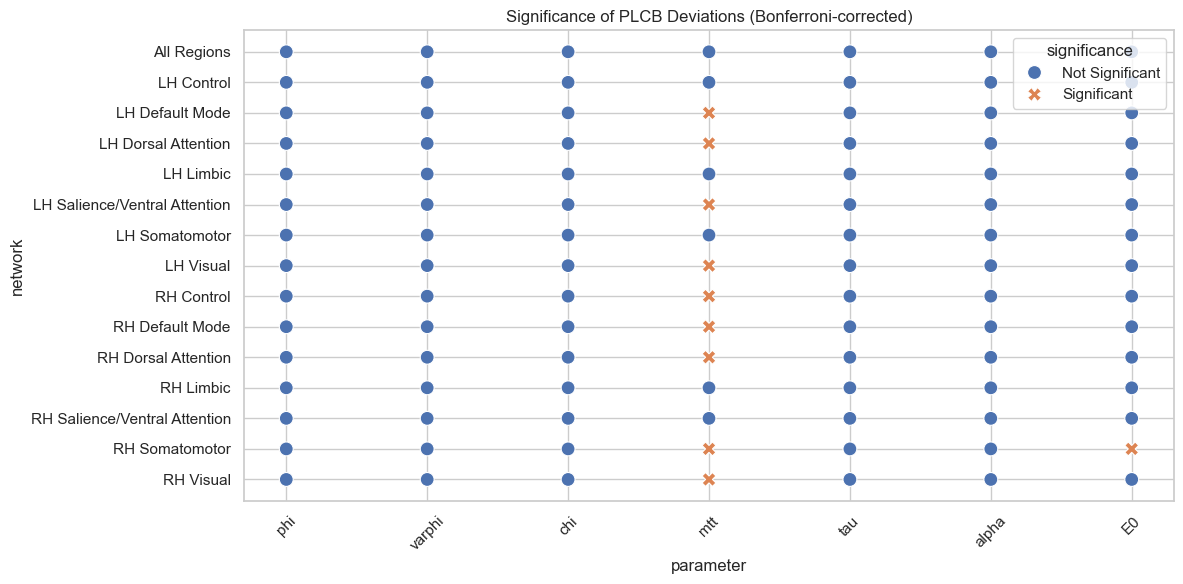

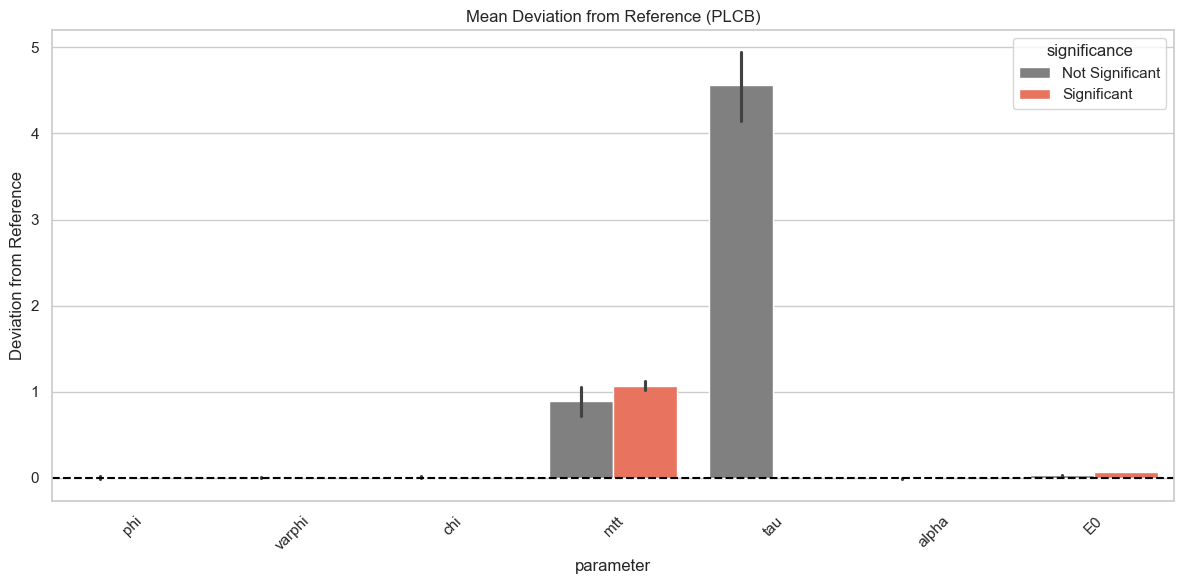

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df.pivot(index="network", columns="parameter", values="p_bonferroni")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (PLCB vs Reference, Bonferroni-corrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df["significance"] = results_df["reject_bonferroni"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of PLCB Deviations (Bonferroni-corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results_df["mean_diff"] = results_df["mean"] - results_df["reference"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df, x="parameter", y="mean_diff", hue="significance",
    palette={"Significant": "tomato", "Not Significant": "gray"}
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Mean Deviation from Reference (PLCB)")
plt.ylabel("Deviation from Reference")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


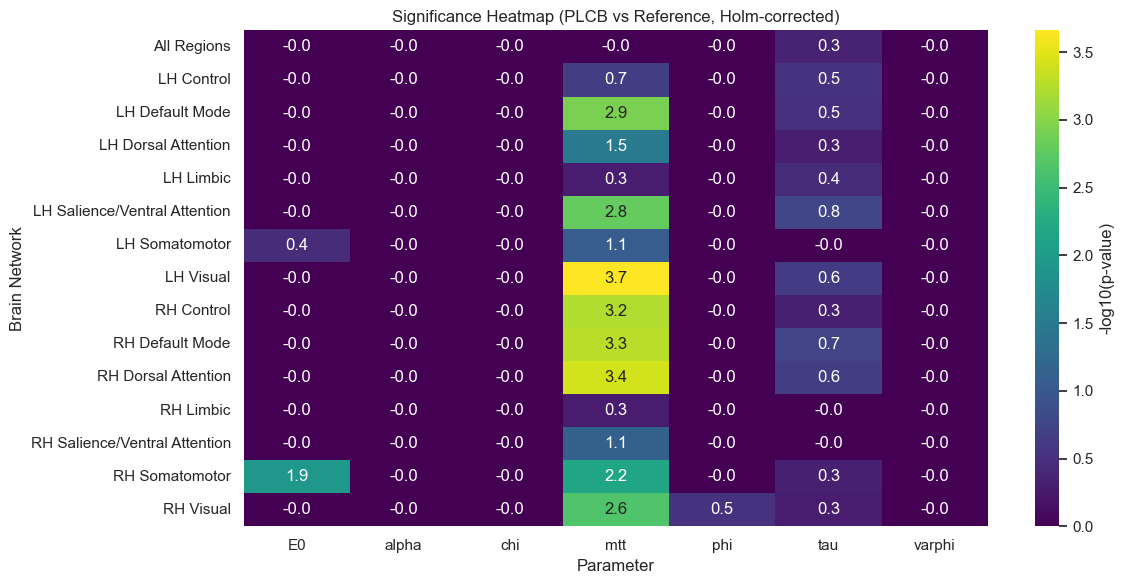

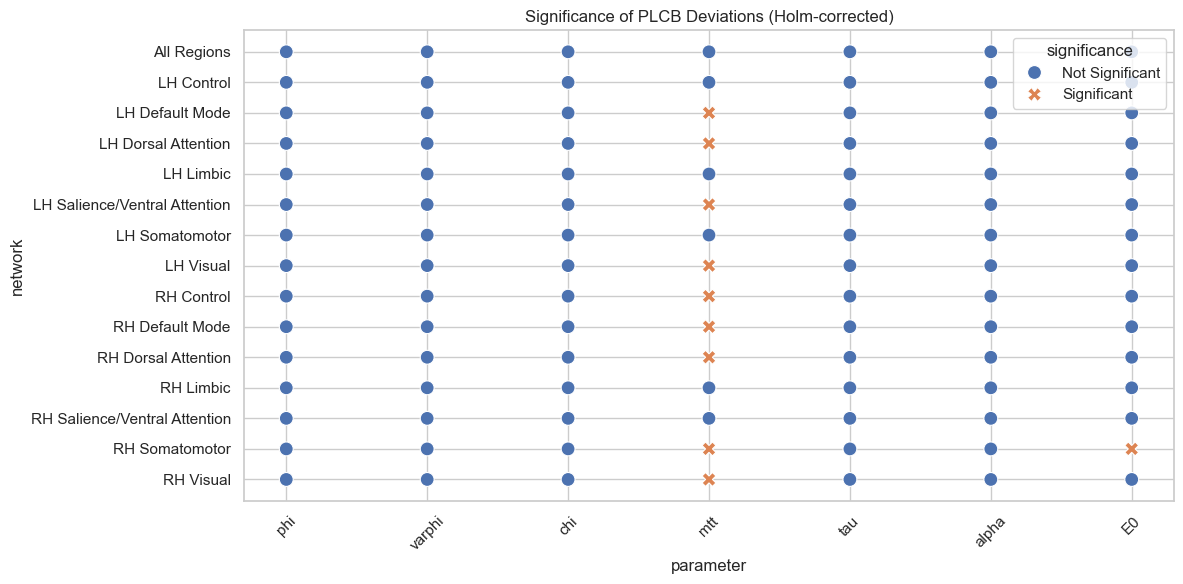

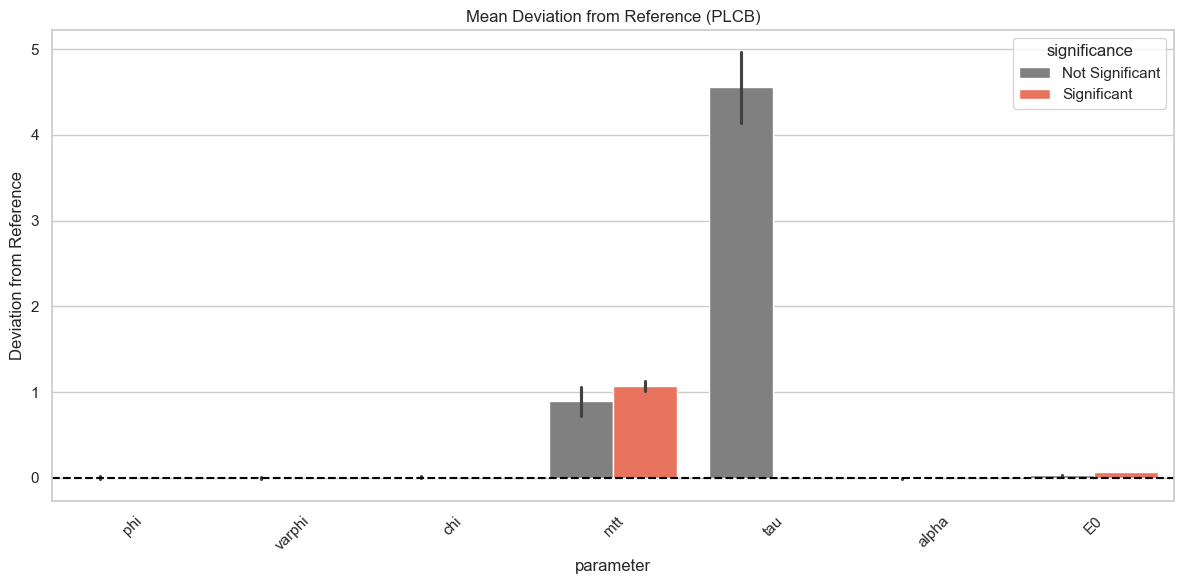

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df.pivot(index="network", columns="parameter", values="p_holm")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (PLCB vs Reference, Holm-corrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df["significance"] = results_df["reject_holm"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of PLCB Deviations (Holm-corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results_df["mean_diff"] = results_df["mean"] - results_df["reference"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df, x="parameter", y="mean_diff", hue="significance",
    palette={"Significant": "tomato", "Not Significant": "gray"}
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Mean Deviation from Reference (PLCB)")
plt.ylabel("Deviation from Reference")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### LSD

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

sns.set(style="whitegrid")

df = pd.read_csv("spdcm_all_data.csv")

# Define parameters of interest
params = ["phi", "varphi", "chi", "mtt", "tau", "alpha", "E0"]

# Reference values 
reference_values = {
    "phi": 1.5, "varphi": 0.6, "chi": 0.6, "mtt": 2.0, "tau": 4.0,
    "alpha": 0.32, "E0": 0.4
}

# Define networks and associated ROI indices
network_rois = {
    "All Regions": list(range(100)),
    "LH Visual": list(range(0, 9)),
    "RH Visual": list(range(50, 58)),
    "LH Somatomotor": list(range(9, 15)),
    "RH Somatomotor": list(range(58, 66)),
    "LH Dorsal Attention": list(range(15, 23)),
    "RH Dorsal Attention": list(range(66, 72)),
    "LH Salience/Ventral Attention": list(range(23, 30)),
    "RH Salience/Ventral Attention": list(range(73, 77)),
    "LH Limbic": list(range(30, 33)),
    "RH Limbic": list(range(78, 80)),
    "LH Control": list(range(33, 37)),
    "RH Control": list(range(80, 88)),
    "LH Default Mode": list(range(37, 50)),
    "RH Default Mode": list(range(89, 100))
}

# Map ROIs to networks
roi_to_network = {}
for net, rois in network_rois.items():
    for roi in rois:
        roi_to_network[roi] = net

df["network"] = df["roi"].map(roi_to_network)

# Group and average per subject/network/condition
agg_df = df[df["parameter"].isin(params)].groupby(
    ["subject", "network", "experiment", "parameter"]
)["value"].mean().reset_index()

# Run one-sample t-tests per (network, parameter)
results = []

for net in agg_df["network"].unique():
    for param in params:
        subdf = agg_df[(agg_df["network"] == net) & (agg_df["parameter"] == param) & (agg_df["experiment"] == "LSD")]
        if len(subdf) < 5:
            continue  # Skip if too few data points

        values = subdf["value"].dropna()
        ref = reference_values.get(param, 0.0)
        t_stat, p_val = ttest_1samp(values, popmean=ref)

        results.append({
            "network": net,
            "parameter": param,
            "mean": values.mean(),
            "std": values.std(),
            "n": len(values),
            "reference": ref,
            "t_stat": t_stat,
            "p_value": p_val
        })

results_df_lsd = pd.DataFrame(results)

# Apply FDR, Bonferroni, Holm
pvals = results_df_lsd["p_value"].values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

results_df_lsd["p_fdr_bh"] = p_fdr
results_df_lsd["reject_fdr_bh"] = rej_fdr
results_df_lsd["p_bonferroni"] = p_bonf
results_df_lsd["reject_bonferroni"] = rej_bonf
results_df_lsd["p_holm"] = p_holm
results_df_lsd["reject_holm"] = rej_holm
results_df_lsd["reject_raw"] = results_df_lsd["p_value"] < 0.05

def interpret_p(p):
    if p < 0.001:
        return "highly significant"
    elif p < 0.01:
        return "significant"
    elif p < 0.05:
        return "marginally significant"
    else:
        return "not significant"

def interpret_result(p, mean, ref):
    direction = "↑ above ref" if mean > ref else "↓ below ref"
    return f"{interpret_p(p)}, {direction}"

# Add interpretation
results_df_lsd["interpret_raw"] = results_df_lsd.apply(
    lambda row: interpret_result(row["p_value"], row["mean"], row["reference"]), axis=1)
results_df_lsd["interpret_fdr_bh"] = results_df_lsd.apply(
    lambda row: interpret_result(row["p_fdr_bh"], row["mean"], row["reference"]), axis=1)
results_df_lsd["interpret_bonferroni"] = results_df_lsd.apply(
    lambda row: interpret_result(row["p_bonferroni"], row["mean"], row["reference"]), axis=1)
results_df_lsd["interpret_holm"] = results_df_lsd.apply(
    lambda row: interpret_result(row["p_holm"], row["mean"], row["reference"]), axis=1)

# Order columns and sort
results_df_lsd = results_df_lsd[[
    "network", "parameter", "mean", "std", "n", "reference", "t_stat", "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

results_df_lsd.sort_values("network", inplace=True)
results_df_lsd


,network,parameter,mean,std,n,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
0,All Regions,phi,1.544629,0.108403,10,1.5,1.301893,2.252857e-01,False,"not significant, ↑ above ref",0.430091,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
1,All Regions,varphi,0.632036,0.079811,10,0.6,1.269336,2.361612e-01,False,"not significant, ↑ above ref",0.439285,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
2,All Regions,chi,0.596590,0.083604,10,0.6,-0.128974,9.002142e-01,False,"not significant, ↓ below ref",0.951783,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
3,All Regions,mtt,3.578498,0.721616,10,2.0,6.917325,6.931830e-05,True,"highly significant, ↑ above ref",0.000962,True,"highly significant, ↑ above ref",0.007278,True,"significant, ↑ above ref",0.006863,True,"significant, ↑ above ref"
4,All Regions,tau,8.227747,4.138872,10,4.0,3.230182,1.031964e-02,True,"marginally significant, ↑ above ref",0.033861,True,"marginally significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",0.776732,False,"not significant, ↑ above ref"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,RH Visual,varphi,0.609300,0.044480,10,0.6,0.661156,5.250741e-01,False,"not significant, ↑ above ref",0.716258,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
100,RH Visual,chi,0.600901,0.049608,10,0.6,0.057439,9.554507e-01,False,"not significant, ↑ above ref",0.964638,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
101,RH Visual,mtt,3.364980,0.280072,10,2.0,15.411923,8.913904e-08,True,"highly significant, ↑ above ref",0.000004,True,"highly significant, ↑ above ref",0.000009,True,"highly significant, ↑ above ref",0.000009,True,"highly significant, ↑ above ref"
102,RH Visual,tau,8.727012,5.284790,10,4.0,2.828518,1.977016e-02,True,"marginally significant, ↑ above ref",0.057663,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"


In [15]:
# Filter rows where raw p-value is not significant
nonsig_df_lsd = results_df_lsd[results_df_lsd["p_value"] >= 0.05].copy()


nonsig_df_lsd.sort_values("network", ascending=False, inplace=True)


nonsig_df_lsd

,network,parameter,mean,std,n,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
104,RH Visual,E0,0.425107,0.051546,10,0.40,1.540260,0.157884,False,"not significant, ↑ above ref",0.345371,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
100,RH Visual,chi,0.600901,0.049608,10,0.60,0.057439,0.955451,False,"not significant, ↑ above ref",0.964638,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
99,RH Visual,varphi,0.609300,0.044480,10,0.60,0.661156,0.525074,False,"not significant, ↑ above ref",0.716258,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
98,RH Visual,phi,1.564928,0.115198,10,1.50,1.782340,0.108375,False,"not significant, ↑ above ref",0.258622,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
103,RH Visual,alpha,0.315603,0.036942,10,0.32,-0.376392,0.715346,False,"not significant, ↓ below ref",0.843947,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,LH Control,alpha,0.291814,0.057357,10,0.32,-1.553968,0.154612,False,"not significant, ↓ below ref",0.345371,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
2,All Regions,chi,0.596590,0.083604,10,0.60,-0.128974,0.900214,False,"not significant, ↓ below ref",0.951783,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
1,All Regions,varphi,0.632036,0.079811,10,0.60,1.269336,0.236161,False,"not significant, ↑ above ref",0.439285,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
5,All Regions,alpha,0.342495,0.095012,10,0.32,0.748689,0.473156,False,"not significant, ↑ above ref",0.662419,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"


In [16]:
# Bonferroni non-significant
nonsig_bonf_lsd = results_df_lsd[results_df_lsd["reject_bonferroni"] == False]
nonsig_bonf_lsd

,network,parameter,mean,std,n,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
0,All Regions,phi,1.544629,0.108403,10,1.50,1.301893,0.225286,False,"not significant, ↑ above ref",0.430091,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
1,All Regions,varphi,0.632036,0.079811,10,0.60,1.269336,0.236161,False,"not significant, ↑ above ref",0.439285,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
2,All Regions,chi,0.596590,0.083604,10,0.60,-0.128974,0.900214,False,"not significant, ↓ below ref",0.951783,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
4,All Regions,tau,8.227747,4.138872,10,4.00,3.230182,0.010320,True,"marginally significant, ↑ above ref",0.033861,True,"marginally significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",0.776732,False,"not significant, ↑ above ref"
5,All Regions,alpha,0.342495,0.095012,10,0.32,0.748689,0.473156,False,"not significant, ↑ above ref",0.662419,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,RH Visual,phi,1.564928,0.115198,10,1.50,1.782340,0.108375,False,"not significant, ↑ above ref",0.258622,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
99,RH Visual,varphi,0.609300,0.044480,10,0.60,0.661156,0.525074,False,"not significant, ↑ above ref",0.716258,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
100,RH Visual,chi,0.600901,0.049608,10,0.60,0.057439,0.955451,False,"not significant, ↑ above ref",0.964638,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
102,RH Visual,tau,8.727012,5.284790,10,4.00,2.828518,0.019770,True,"marginally significant, ↑ above ref",0.057663,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"


In [17]:
# Holm non-significant
nonsig_holm_lsd = results_df_lsd[results_df_lsd["reject_holm"] == False]
nonsig_holm_lsd

,network,parameter,mean,std,n,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
0,All Regions,phi,1.544629,0.108403,10,1.50,1.301893,0.225286,False,"not significant, ↑ above ref",0.430091,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
1,All Regions,varphi,0.632036,0.079811,10,0.60,1.269336,0.236161,False,"not significant, ↑ above ref",0.439285,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
2,All Regions,chi,0.596590,0.083604,10,0.60,-0.128974,0.900214,False,"not significant, ↓ below ref",0.951783,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.000000,False,"not significant, ↓ below ref"
4,All Regions,tau,8.227747,4.138872,10,4.00,3.230182,0.010320,True,"marginally significant, ↑ above ref",0.033861,True,"marginally significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",0.776732,False,"not significant, ↑ above ref"
5,All Regions,alpha,0.342495,0.095012,10,0.32,0.748689,0.473156,False,"not significant, ↑ above ref",0.662419,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,RH Visual,phi,1.564928,0.115198,10,1.50,1.782340,0.108375,False,"not significant, ↑ above ref",0.258622,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
99,RH Visual,varphi,0.609300,0.044480,10,0.60,0.661156,0.525074,False,"not significant, ↑ above ref",0.716258,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
100,RH Visual,chi,0.600901,0.049608,10,0.60,0.057439,0.955451,False,"not significant, ↑ above ref",0.964638,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"
102,RH Visual,tau,8.727012,5.284790,10,4.00,2.828518,0.019770,True,"marginally significant, ↑ above ref",0.057663,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.000000,False,"not significant, ↑ above ref"


In [18]:
# Filter where none of the tests show significant difference
consistently_nonsig_lsd = results_df_lsd[
    (results_df_lsd["reject_raw"] == False) &
    (results_df_lsd["reject_fdr_bh"] == False) &
    (results_df_lsd["reject_bonferroni"] == False) &
    (results_df_lsd["reject_holm"] == False)
]


consistently_nonsig_lsd = consistently_nonsig_lsd.sort_values("network")


consistently_nonsig_lsd


,network,parameter,mean,std,n,reference,t_stat,p_value,reject_raw,interpret_raw,p_fdr_bh,reject_fdr_bh,interpret_fdr_bh,p_bonferroni,reject_bonferroni,interpret_bonferroni,p_holm,reject_holm,interpret_holm
0,All Regions,phi,1.544629,0.108403,10,1.50,1.301893,0.225286,False,"not significant, ↑ above ref",0.430091,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
1,All Regions,varphi,0.632036,0.079811,10,0.60,1.269336,0.236161,False,"not significant, ↑ above ref",0.439285,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
2,All Regions,chi,0.596590,0.083604,10,0.60,-0.128974,0.900214,False,"not significant, ↓ below ref",0.951783,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
5,All Regions,alpha,0.342495,0.095012,10,0.32,0.748689,0.473156,False,"not significant, ↑ above ref",0.662419,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
12,LH Control,alpha,0.291814,0.057357,10,0.32,-1.553968,0.154612,False,"not significant, ↓ below ref",0.345371,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,RH Visual,varphi,0.609300,0.044480,10,0.60,0.661156,0.525074,False,"not significant, ↑ above ref",0.716258,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
100,RH Visual,chi,0.600901,0.049608,10,0.60,0.057439,0.955451,False,"not significant, ↑ above ref",0.964638,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"
103,RH Visual,alpha,0.315603,0.036942,10,0.32,-0.376392,0.715346,False,"not significant, ↓ below ref",0.843947,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref",1.0,False,"not significant, ↓ below ref"
98,RH Visual,phi,1.564928,0.115198,10,1.50,1.782340,0.108375,False,"not significant, ↑ above ref",0.258622,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref",1.0,False,"not significant, ↑ above ref"


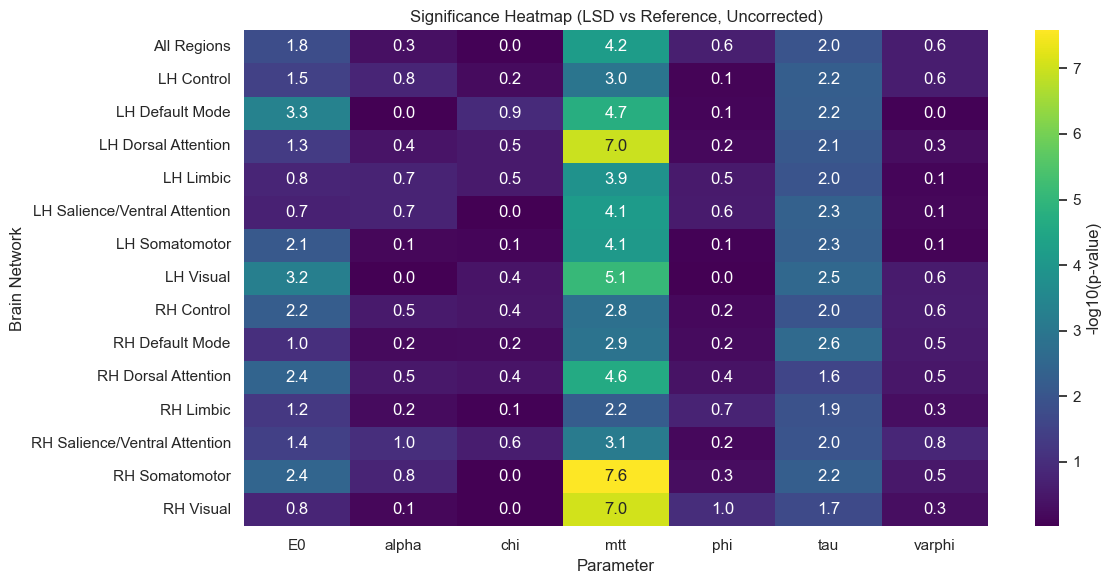

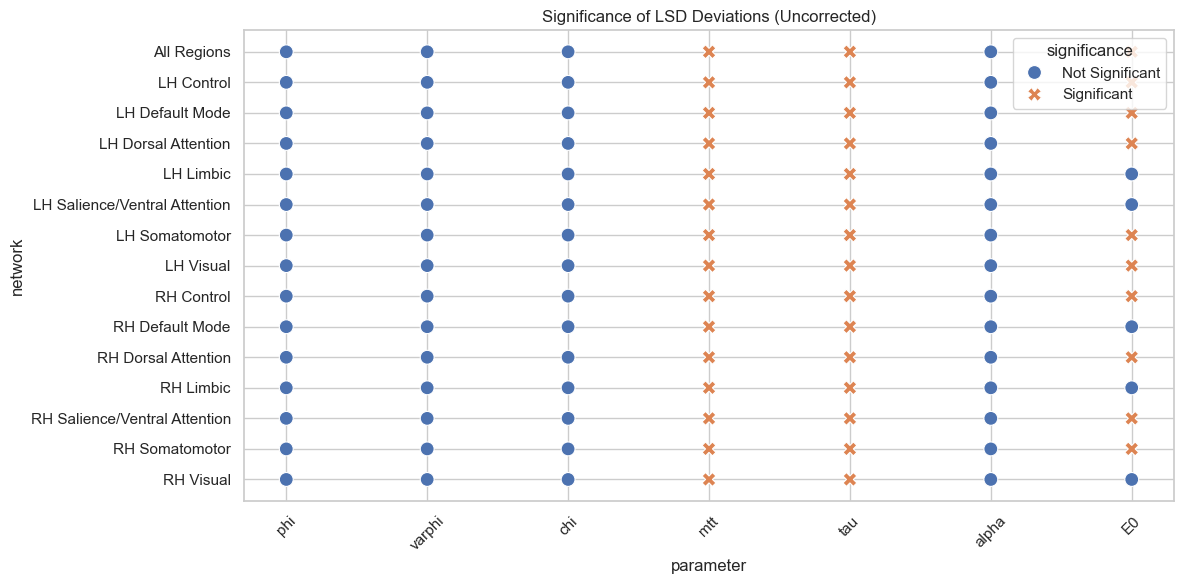

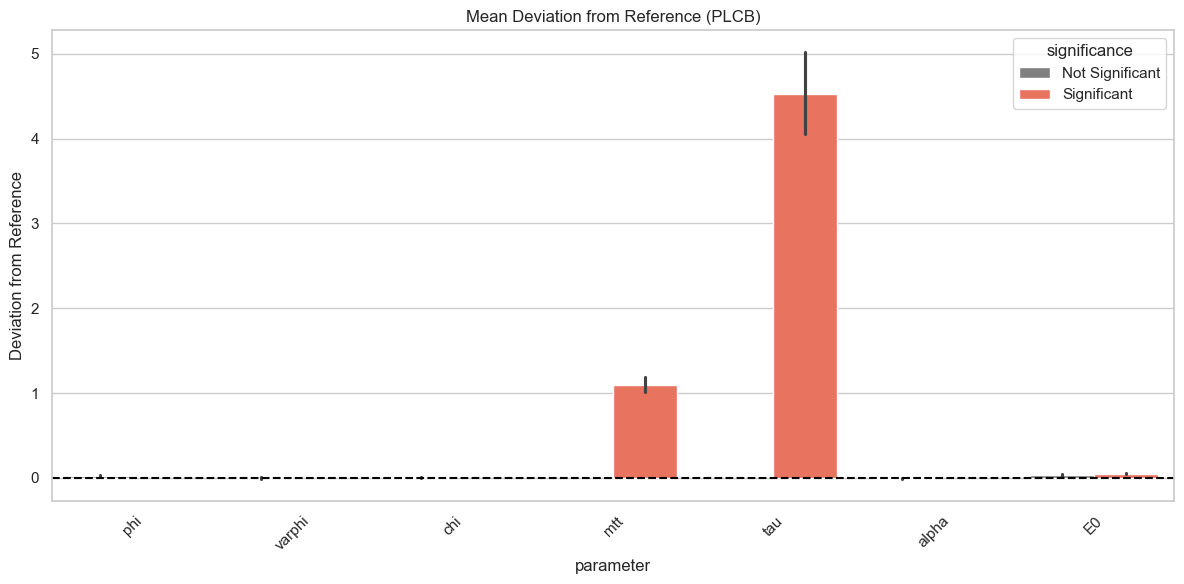

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df_lsd.pivot(index="network", columns="parameter", values="p_value")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (LSD vs Reference, Uncorrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df_lsd["significance"] = results_df_lsd["reject_raw"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df_lsd,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD Deviations (Uncorrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results_df_lsd["mean_diff"] = results_df_lsd["mean"] - results_df_lsd["reference"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df_lsd, x="parameter", y="mean_diff", hue="significance",
    palette={"Significant": "tomato", "Not Significant": "gray"}
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Mean Deviation from Reference (PLCB)")
plt.ylabel("Deviation from Reference")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


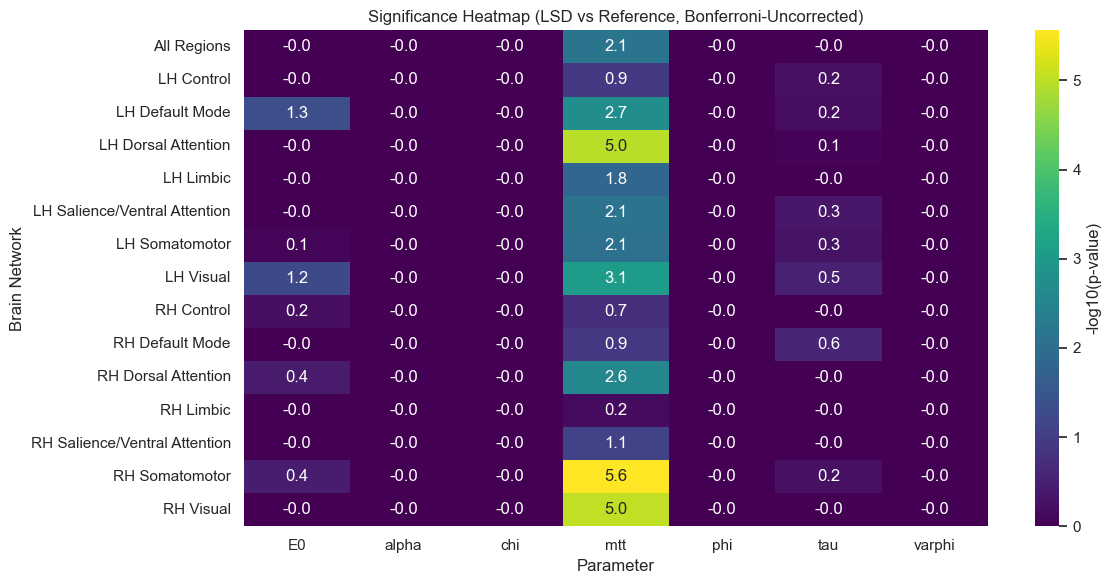

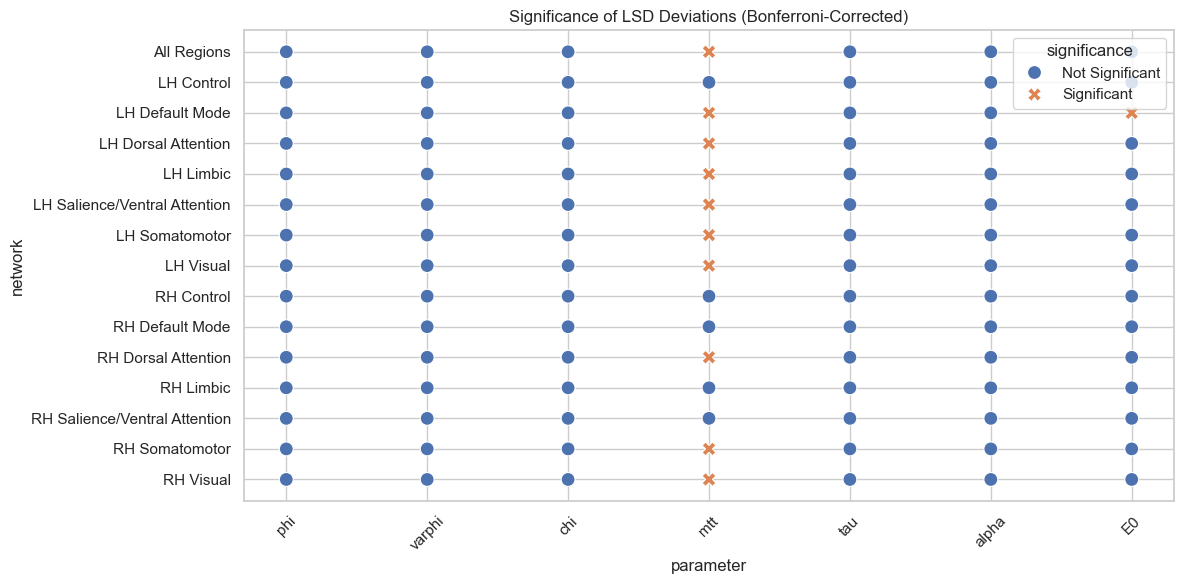

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df_lsd.pivot(index="network", columns="parameter", values="p_bonferroni")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (LSD vs Reference, Bonferroni-Uncorrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df_lsd["significance"] = results_df_lsd["reject_bonferroni"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df_lsd,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD Deviations (Bonferroni-Corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



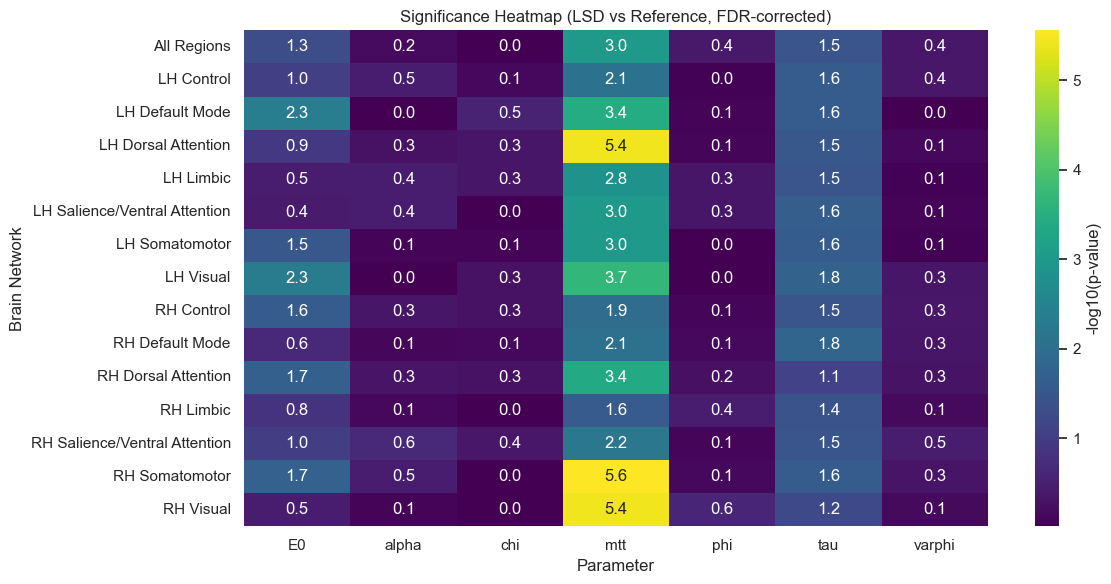

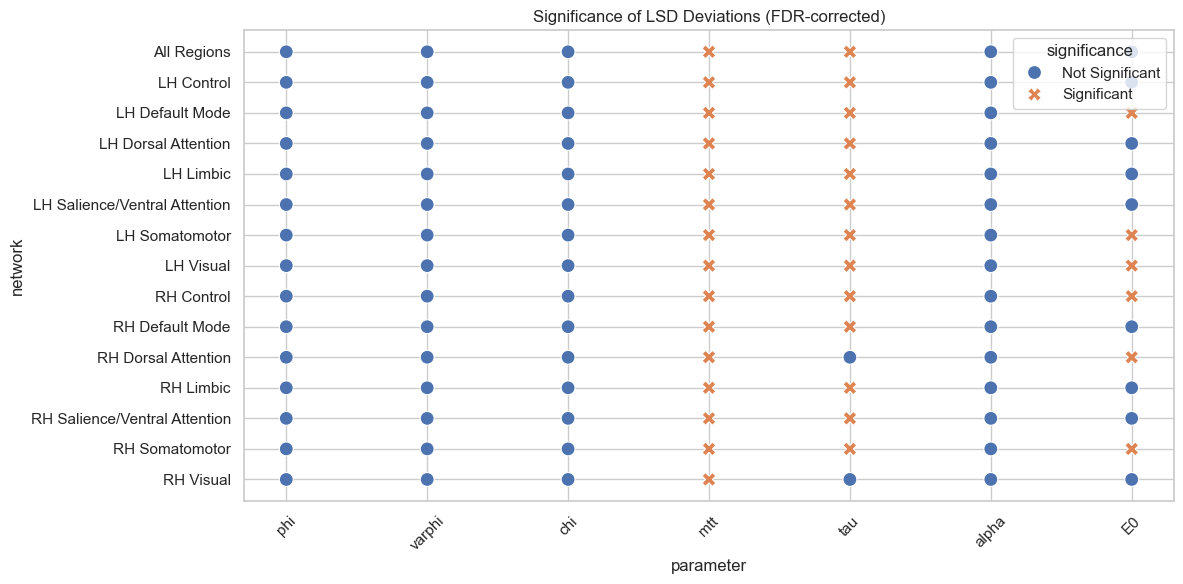

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df_lsd.pivot(index="network", columns="parameter", values="p_fdr_bh")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (LSD vs Reference, FDR-corrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df_lsd["significance"] = results_df_lsd["reject_fdr_bh"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df_lsd,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD Deviations (FDR-corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



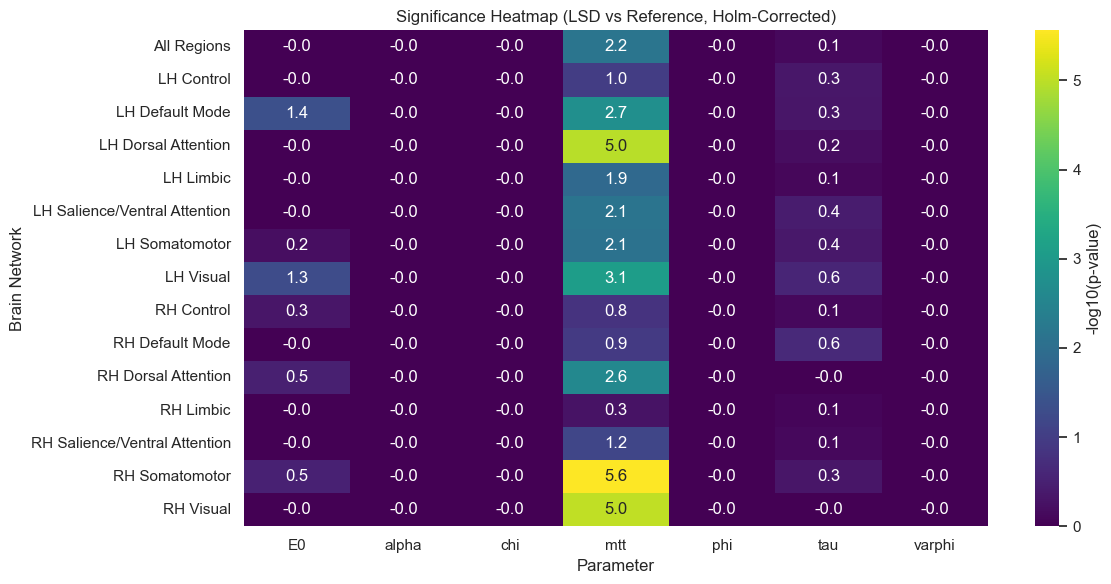

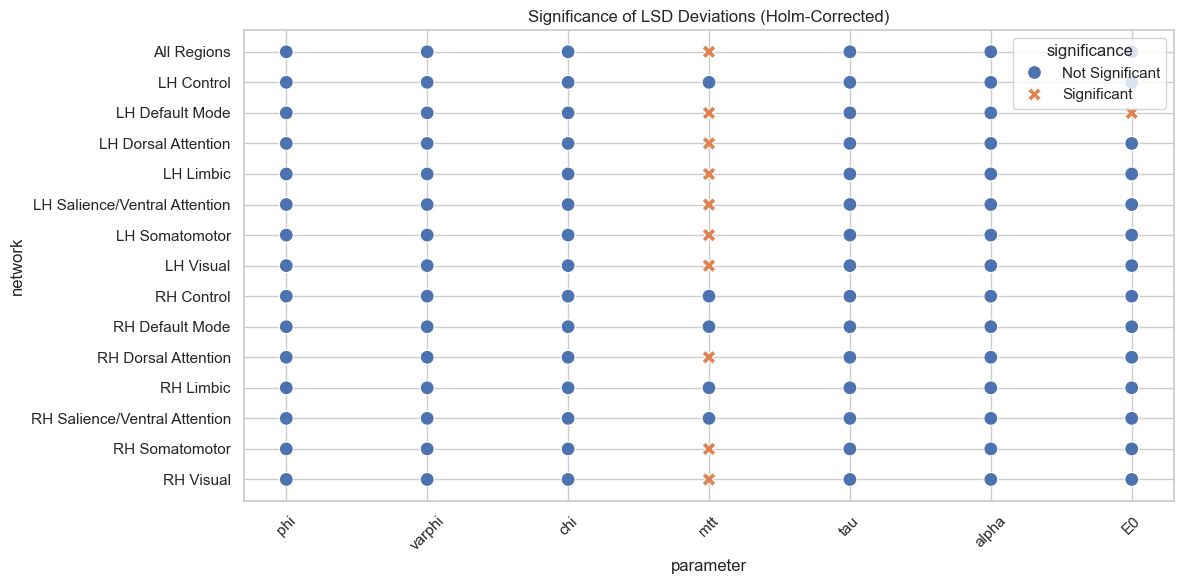

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df_lsd.pivot(index="network", columns="parameter", values="p_holm")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (LSD vs Reference, Holm-Corrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df_lsd["significance"] = results_df_lsd["reject_holm"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df_lsd,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD Deviations (Holm-Corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



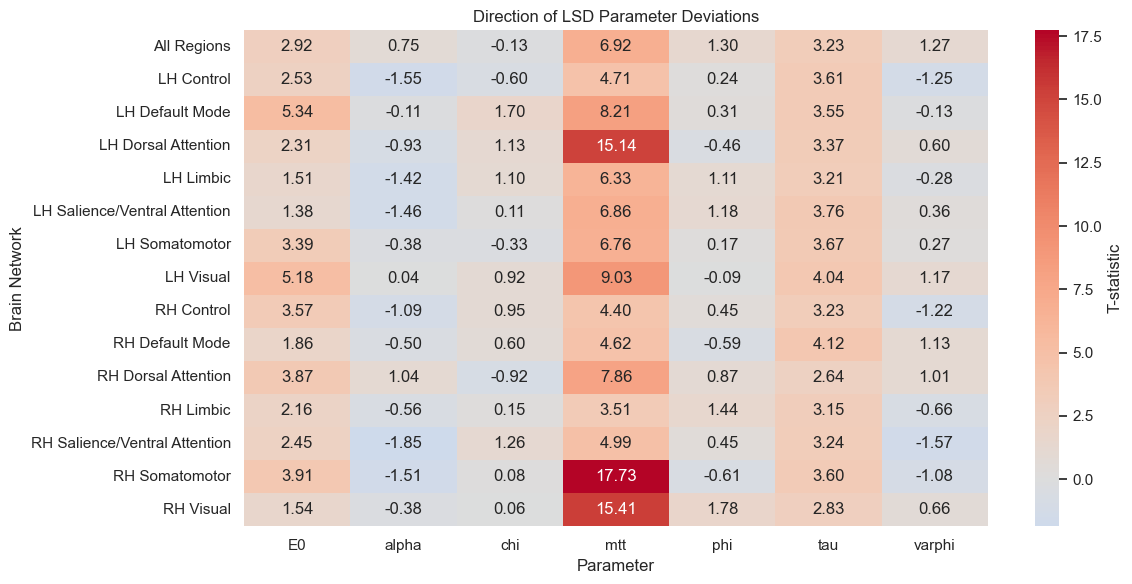

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

heatmap_vals_lsd = results_df_lsd.copy()

heatmap_matrix_lsd = heatmap_vals_lsd.pivot(index="network", columns="parameter", values="t_stat")

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_matrix_lsd,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "T-statistic"}
)
plt.title("Direction of LSD Parameter Deviations")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()


Paired t-tests (fitted vs baseline):
mse: t=40.355, p=0, mean Δ=2.0069 (↑)
nmse: t=38.348, p=0, mean Δ=0.9058 (↑)
relative_error: t=58.258, p=0, mean Δ=0.2424 (↑)
explained_variance: t=32.436, p=2.737e-226, mean Δ=0.0669 (↑)
pearson_corr: t=164.876, p=0, mean Δ=0.2139 (↑)
coherence: t=200.911, p=0, mean Δ=0.1712 (↑)


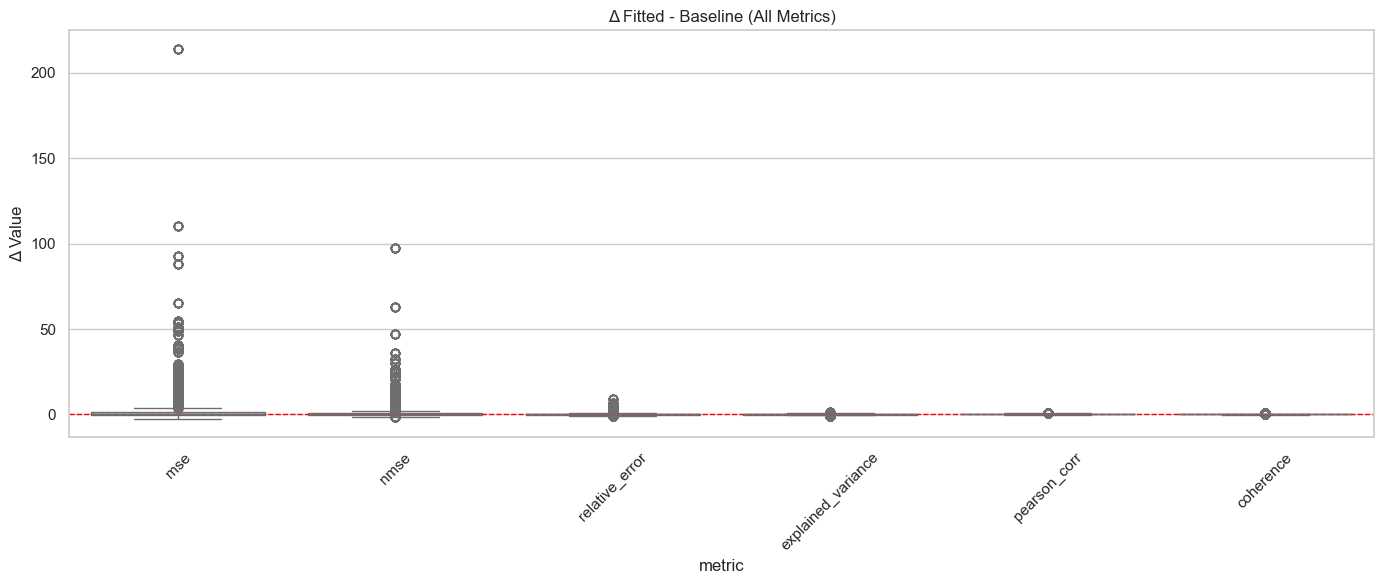

/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_95241/3669402739.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_95241/3669402739.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)


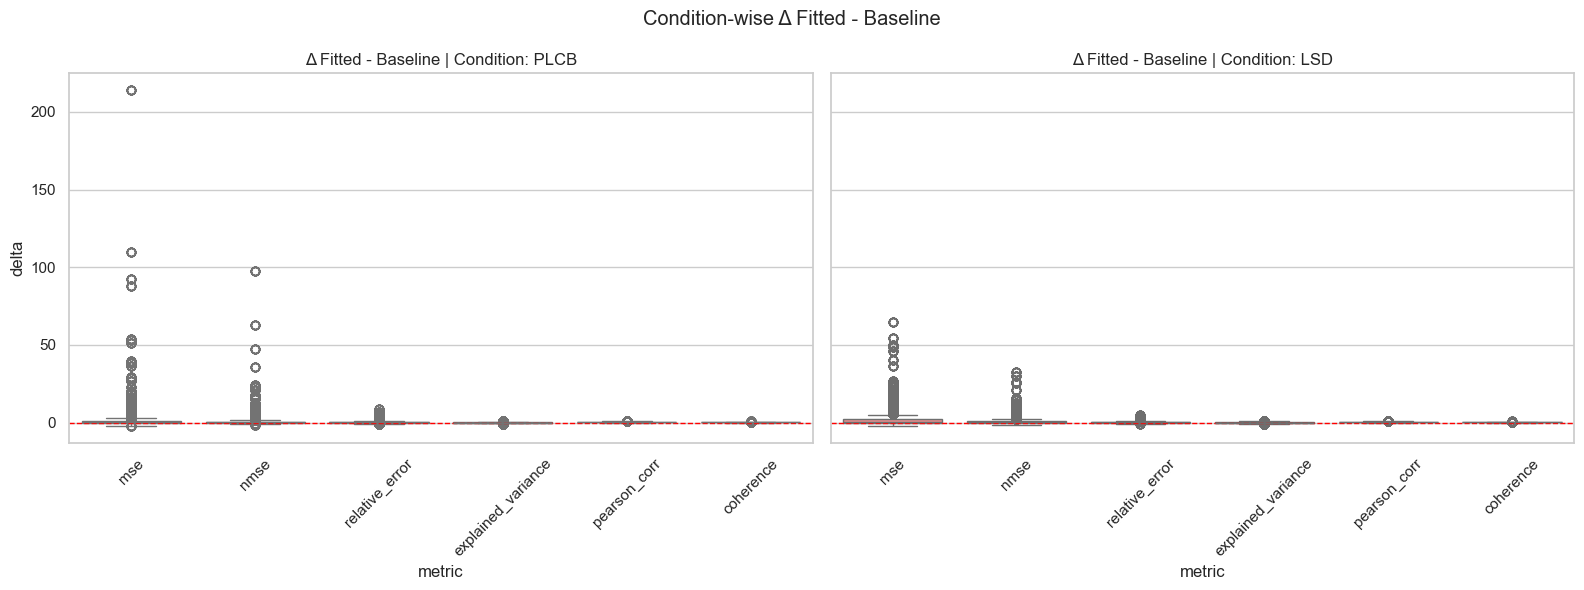

/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_95241/3669402739.py:68: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=metrics_df, x="metric", y="delta", hue="experiment",


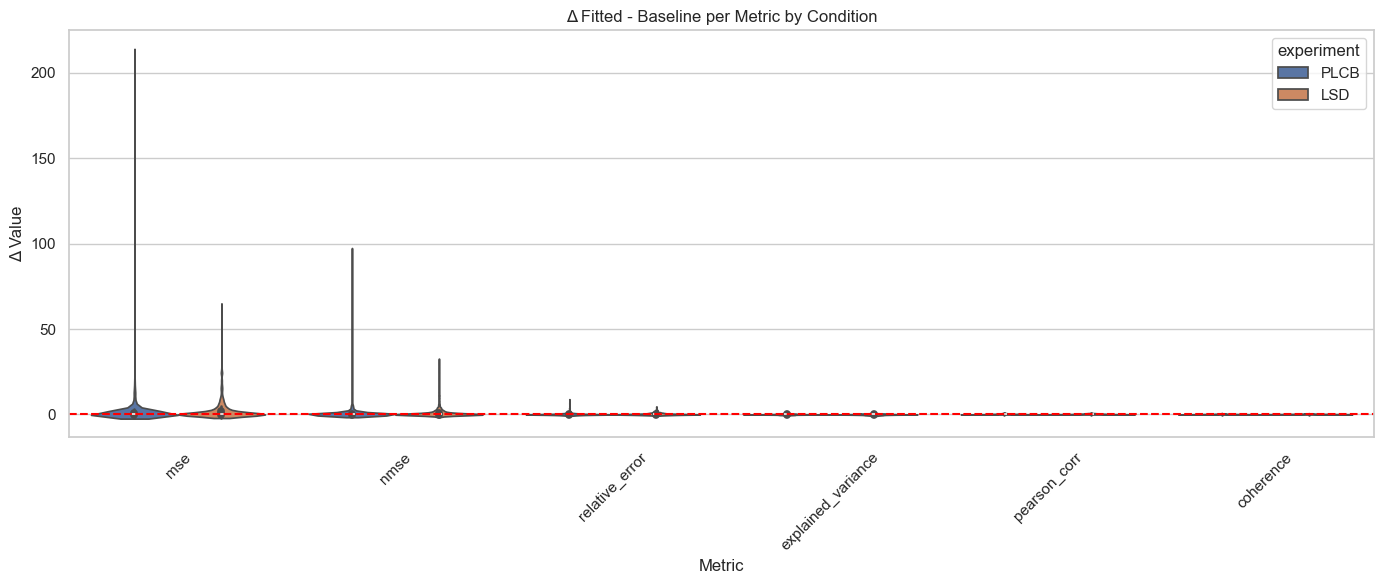

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel


df = pd.read_csv("spdcm_all_data.csv")

# Define evaluation metrics
metrics_to_use = ["mse", "nmse", "relative_error", "explained_variance",
                  "pearson_corr","coherence"]

# Melt fitted and baseline values
rows = []
for m in metrics_to_use:
    raw_col = f"{m}_norm"
    base_col = f"baseline_{m}_norm"

    if raw_col in df.columns and base_col in df.columns:
        for _, row in df.iterrows():
            if not pd.isna(row[raw_col]) and not pd.isna(row[base_col]):
                rows.append({
                    "subject": row["subject"],
                    "roi": row["roi"],
                    "experiment": row["experiment"],
                    "metric": m,
                    "fitted": row[raw_col],
                    "baseline": row[base_col],
                    "delta": row[raw_col] - row[base_col]
                })

metrics_df = pd.DataFrame(rows)

print("Paired t-tests (fitted vs baseline):")
for metric in metrics_to_use:
    sub_df = metrics_df[metrics_df["metric"] == metric]
    x = sub_df["fitted"]
    y = sub_df["baseline"]
    valid = x.notna() & y.notna()
    t_stat, p_val = ttest_rel(x[valid], y[valid])
    mean_change = (x - y).mean()
    direction = "↓" if mean_change < 0 else "↑"
    print(f"{metric}: t={t_stat:.3f}, p={p_val:.4g}, mean Δ={mean_change:.4f} ({direction})")

plt.figure(figsize=(14, 6))
sns.boxplot(data=metrics_df, x="metric", y="delta", color="skyblue")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Δ Fitted - Baseline (All Metrics)")
plt.ylabel("Δ Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for i, cond in enumerate(["PLCB", "LSD"]):
    subset = metrics_df[metrics_df["experiment"] == cond]
    sns.boxplot(data=subset, x="metric", y="delta", ax=axs[i],
                color="lightgreen" if cond == "PLCB" else "lightcoral")
    axs[i].axhline(0, color="red", linestyle="--", linewidth=1)
    axs[i].set_title(f"Δ Fitted - Baseline | Condition: {cond}")
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
plt.suptitle("Condition-wise Δ Fitted - Baseline")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(data=metrics_df, x="metric", y="delta", hue="experiment",
               inner="box", scale="width", cut=0)
plt.axhline(0, color='red', linestyle='--')
plt.title("Δ Fitted - Baseline per Metric by Condition")
plt.ylabel("Δ Value")
plt.xlabel("Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_95241/1551503362.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=20)


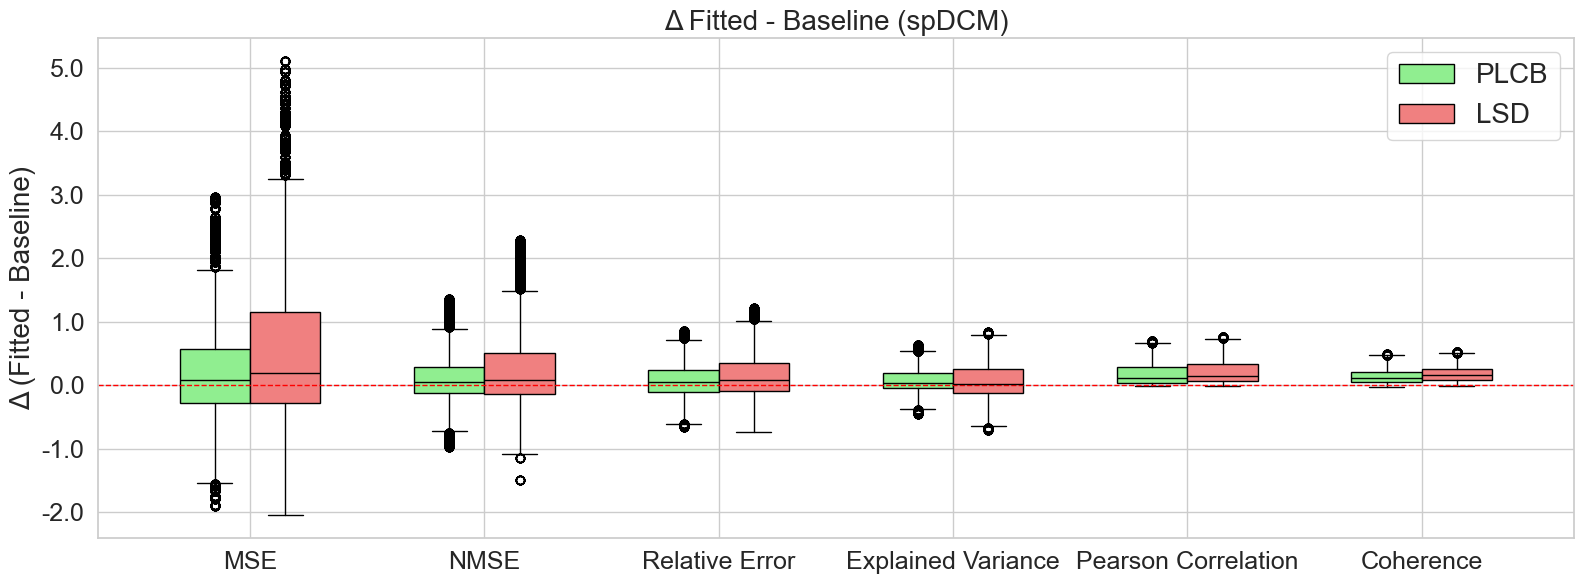

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

metrics_to_use = ["mse", "nmse", "relative_error", "explained_variance", "pearson_corr", "coherence"]
metric_label_map = {
    "mse": "MSE",
    "nmse": "NMSE",
    "relative_error": "Relative Error",
    "explained_variance": "Explained Variance",
    "pearson_corr": "Pearson Correlation",
    "coherence": "Coherence"
}
display_labels = [metric_label_map[m] for m in metrics_to_use]
positions = np.arange(len(metrics_to_use))
width = 0.3
offset = width / 2

# Filter outliers and organise data
data_plcb = []
data_lsd = []

for metric in metrics_to_use:
    for cond, target_list in zip(["PLCB", "LSD"], [data_plcb, data_lsd]):
        subset = metrics_df[(metrics_df["metric"] == metric) & (metrics_df["experiment"] == cond)]
        if subset.empty:
            target_list.append([])  # append empty list if no data
            continue
        Q1 = subset["delta"].quantile(0.25)
        Q3 = subset["delta"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        non_outliers = subset[(subset["delta"] >= lower_bound) & (subset["delta"] <= upper_bound)]
        target_list.append(non_outliers["delta"].dropna())

fig, ax = plt.subplots(figsize=(16, 6))
positions_plcb = positions - offset
positions_lsd = positions + offset

bp1 = ax.boxplot(data_plcb, positions=positions_plcb, widths=width, patch_artist=True,
                 boxprops=dict(facecolor='lightgreen', color='black'),
                 medianprops=dict(color='black'))

bp2 = ax.boxplot(data_lsd, positions=positions_lsd, widths=width, patch_artist=True,
                 boxprops=dict(facecolor='lightcoral', color='black'),
                 medianprops=dict(color='black'))

ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xticks(positions)
ax.set_xticklabels(display_labels, fontsize=20)
ax.set_yticklabels(ax.get_yticks(), fontsize=20)
ax.set_ylabel("Δ (Fitted - Baseline)", fontsize=20)
ax.set_title("Δ Fitted - Baseline (spDCM)", fontsize=20)
ax.tick_params(labelsize=18)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["PLCB", "LSD"], fontsize=20)

plt.tight_layout()
plt.show()


/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_51014/3412703025.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax.boxplot(data_plcb, positions=positions_plcb, widths=width, patch_artist=True,
/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_51014/3412703025.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=18)


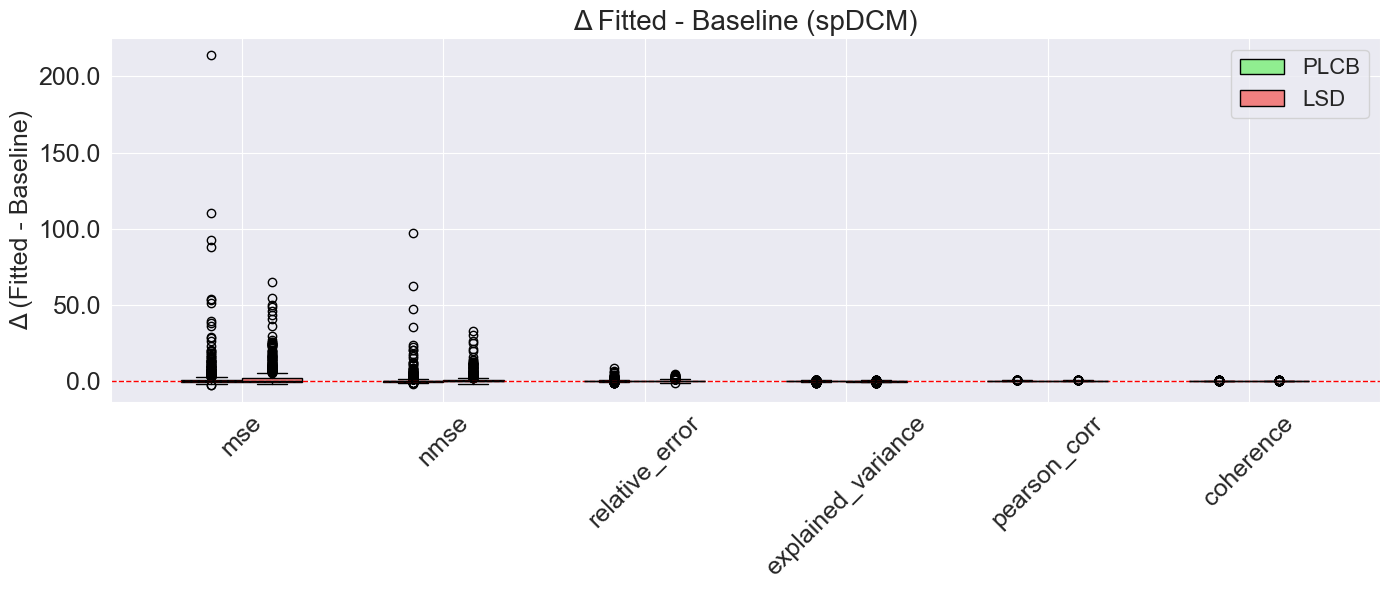

In [5]:
import os
import json
import pandas as pd

base_dir = "/Users/xuenbei/Desktop/finalyearproject/spDCM/fitted_data"
subjects = [1, 2, 3, 4, 6, 10, 11, 12, 19, 20]
rois = list(range(100))
conditions = ["PLCB", "LSD"]
metrics_to_use = ["mse", "nmse", "relative_error", "explained_variance",
                  "pearson_corr", "coherence"]

rows = []

for subj in subjects:
    for roi in rois:
        for exp in conditions:
            prefix = f"roi-{roi}-{exp}"
            folder = os.path.join(base_dir, f"sub-{subj:03d}")

            try:
                with open(os.path.join(folder, f"{prefix}_metrics.json")) as f1, \
                     open(os.path.join(folder, f"{prefix}_baseline_metrics.json")) as f2:

                    fitted = json.load(f1)["normalised_csd_metrics"]
                    baseline = json.load(f2)["normalised_csd_metrics"]

                    row = {"subject": subj, "roi": roi, "condition": exp}
                    for metric in metrics_to_use:
                        row = {
                            "subject": subj,
                            "roi": roi,
                            "condition": exp,
                            "metric": metric,
                            "fitted": fitted.get(metric),
                            "baseline": baseline.get(metric),
                        }
                        row["delta"] = row["fitted"] - row["baseline"] if row["fitted"] is not None and row["baseline"] is not None else None
                        rows.append(row)

            except Exception as e:
                print(f"Missing or error for sub-{subj:03d}, ROI {roi}, {exp}: {e}")

plot_data = pd.DataFrame(rows)
import matplotlib.pyplot as plt
import numpy as np

metric_names = metrics_to_use
positions = np.arange(len(metric_names))

# Offset each condition's boxplot for side-by-side display
width = 0.3
offset = width / 2

fig, ax = plt.subplots(figsize=(14, 6))

# Plot PLCB
subset_plcb = plot_data[plot_data["condition"] == "PLCB"]
data_plcb = [subset_plcb[subset_plcb["metric"] == m]["delta"].dropna() for m in metric_names]
positions_plcb = positions - offset
bp1 = ax.boxplot(data_plcb, positions=positions_plcb, widths=width, patch_artist=True,
                 boxprops=dict(facecolor='lightgreen', color='black'),
                 medianprops=dict(color='black'), labels=metric_names)

# Plot LSD
subset_lsd = plot_data[plot_data["condition"] == "LSD"]
data_lsd = [subset_lsd[subset_lsd["metric"] == m]["delta"].dropna() for m in metric_names]
positions_lsd = positions + offset
bp2 = ax.boxplot(data_lsd, positions=positions_lsd, widths=width, patch_artist=True,
                 boxprops=dict(facecolor='lightcoral', color='black'),
                 medianprops=dict(color='black'))

ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xticks(positions)
ax.set_xticklabels(metric_names, rotation=45, fontsize=16)
ax.set_yticklabels(ax.get_yticks(), fontsize=18)
ax.set_ylabel("Δ (Fitted - Baseline)", fontsize=18)
ax.set_title("Δ Fitted - Baseline (spDCM)", fontsize=20)
ax.tick_params(labelsize=18)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["PLCB", "LSD"], fontsize=16)

plt.tight_layout()
plt.show()
